  **1000 IMDB movies (2006-2016)**


Author: Prarthna Nemade




**ABSTRACT**

Automactic Machine Learning or AutoML refers to the automation of various tasks in the machine learning pipeline, including data preprocessing, hyperparameter tuning, model selection, and evaluation.
In this notebook, I will use an AutoML library H2O to train and predict the model using GLM & GBM, hyperparameter tuning, predict the best model, etc.

In [77]:
##Installing all the required libraries 
!pip install requests
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future
!pip install h2o


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [78]:
# Importing all the libararies required for the assignment
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split as tts
import seaborn as sns
from scipy.stats import pearsonr

sns.set(rc={"figure.figsize": (16, 8)})

In [79]:
# Setting up maximum runtime for the AutoML
min_mem_size = 6
run_time = 222
pct_memory = 0.5
virtual_memory = psutil.virtual_memory()
min_mem_size = int(round(int(pct_memory * virtual_memory.available) / 1073741824, 0))
print(min_mem_size)

4


In [80]:
# Start the H2O server on a random port
port_no = random.randint(5555, 55555)
#  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
try:
    h2o.init(
        strict_version_check=False, min_mem_size_GB=min_mem_size, port=port_no
    )  # start h2o
except:
    logging.critical("h2o.init")
    h2o.download_all_logs(dirname=logs_path, filename=logfile)
    h2o.cluster().shutdown()
    sys.exit(2)

Checking whether there is an H2O instance running at http://localhost:53983..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.17" 2022-10-18; OpenJDK Runtime Environment (build 11.0.17+8-post-Ubuntu-1ubuntu220.04); OpenJDK 64-Bit Server VM (build 11.0.17+8-post-Ubuntu-1ubuntu220.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.8/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpyqnkx_oo
  JVM stdout: /tmp/tmpyqnkx_oo/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpyqnkx_oo/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:53983
Connecting to H2O server at http://127.0.0.1:53983 ... successful.


H2O_cluster_uptime:,06 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.1
H2O_cluster_version_age:,20 days
H2O_cluster_name:,H2O_from_python_unknownUser_j15esp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


EDA
(Exploratory Data Analysis)

In [81]:
dff = pd.read_csv("https://github.com/PrarthanaNemade14/AutoML/raw/main/imdb.csv")  # Reading CSV file into Pandas DataFrame
dff.head()


,Rank,Title,Genre,Description,Director,Actors,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore
0,1,Guardians of the Galaxy,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced ...,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...",2014,121,8.1,757074,333.13,76.0
1,2,Prometheus,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te...",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124,7.0,485820,126.46,65.0
2,3,Split,"Horror,Thriller",Three girls are kidnapped by a man with a diag...,M. Night Shyamalan,"James McAvoy, Anya Taylor-Joy, Haley Lu Richar...",2016,117,7.3,157606,138.12,62.0
3,4,Sing,"Animation,Comedy,Family","In a city of humanoid animals, a hustling thea...",Christophe Lourdelet,"Matthew McConaughey,Reese Witherspoon, Seth Ma...",2016,108,7.2,60545,270.32,59.0
4,5,Suicide Squad,"Action,Adventure,Fantasy",A secret government agency recruits some of th...,David Ayer,"Will Smith, Jared Leto, Margot Robbie, Viola D...",2016,123,6.2,393727,325.02,40.0


In [82]:
dff.isnull().sum()  # Checking for any null values in the dataset

Rank                    0
Title                   0
Genre                   0
Description             0
Director                0
Actors                  0
Year                    0
Runtime (Minutes)       0
Rating                  0
Votes                   0
Revenue (Millions)    128
Metascore              64
dtype: int64

In [83]:
# Printing numerical and categorical columns

numeric_columns = []
categorical_columns = []

# Iterate through each column in the dataset
for column in dff.columns:
    # Checking if the column is of numeric data type
    if dff[column].dtype in ['int64', 'float64']:
        numeric_columns.append(column)
    # Check if the column is of categorical data type
    elif dff[column].dtype in ['object']:
        categorical_columns.append(column)

# Print
print("The Numeric and Categorical values are:")
print("----------------------------------------")
print("Numeric Columns:", numeric_columns)

# Print 
print("\nCategorical Columns:", categorical_columns)


The Numeric and Categorical values are:
----------------------------------------
Numeric Columns: ['Rank', 'Year', 'Runtime (Minutes)', 'Rating', 'Votes', 'Revenue (Millions)', 'Metascore']

Categorical Columns: ['Title', 'Genre', 'Description', 'Director', 'Actors']


In [84]:
# Imputing the null values for "Revenue"

null_val = ['Revenue (Millions)']

#Technique 1: Using mean to impute the missing values
for i in null_val:
 dff.loc[dff.loc[:,i].isna(),i] = dff.loc[:,i].mean()


In [85]:
 #Displaying the imputed data

 dff.isna().sum()  


Rank                   0
Title                  0
Genre                  0
Description            0
Director               0
Actors                 0
Year                   0
Runtime (Minutes)      0
Rating                 0
Votes                  0
Revenue (Millions)     0
Metascore             64
dtype: int64

In [86]:
# Imputing the null values for "Metascore" using KNN

from sklearn.impute import KNNImputer

null_value = dff.iloc[:, 11:12]

# Create an imputer object
imputer = KNNImputer(n_neighbors=5)

# Fit the imputer to the column
null_value_imputed = imputer.fit_transform(null_value)

# Replace the original column with the imputed column
dff.iloc[:, 11:12] = null_value_imputed

In [87]:
#displaying imputed data

dff.isna().sum()


Rank                  0
Title                 0
Genre                 0
Description           0
Director              0
Actors                0
Year                  0
Runtime (Minutes)     0
Rating                0
Votes                 0
Revenue (Millions)    0
Metascore             0
dtype: int64

In [88]:
#description of the statistical data

dff.describe()

,Rank,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore
count,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000
mean,500.500000,2012.783000,113.172000,6.723200,1.698083e+05,82.956376,58.985043
std,288.819436,3.205962,18.810908,0.945429,1.887626e+05,96.412043,16.634858
min,1.000000,2006.000000,66.000000,1.900000,6.100000e+01,0.000000,11.000000
25%,250.750000,2010.000000,100.000000,6.200000,3.630900e+04,17.442500,47.750000
50%,500.500000,2014.000000,111.000000,6.800000,1.107990e+05,60.375000,58.985043
75%,750.250000,2016.000000,123.000000,7.400000,2.399098e+05,99.177500,71.000000
max,1000.000000,2016.000000,191.000000,9.000000,1.791916e+06,936.630000,100.000000


This table shows summary statistics for a dataset with 1000 observations and 07 variables.

The variables are: Rank, Year, Runtime (Minutes), Rating, Votes, Revenue(Millions), Metascore.

The "count" row shows the number of observations for each variable, while the "mean" row shows the average value of each variable.

The "std" row shows the standard deviation of each variable, which is a measure of how much the values vary from the mean.

The "min" and "max" rows show the smallest and largest values observed for each variable.

The "25%", "50%", and "75%" rows show the values at the 25th, 50th, and 75th percentiles of the distribution, respectively.

These percentiles divide the observations into quarters, with the 25th percentile being the value below which 25% of the observations fall, and so on.

In [89]:
# * Which predictor variables are the most important?

#Using OLS for finding the p value to check the significant features
import statsmodels.api as sm

model = sm.OLS(dff['Votes'], dff[['Rank',  'Year', 'Runtime (Minutes)', 'Rating', 'Votes']]).fit()

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Votes   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.137e+33
Date:                Wed, 01 Mar 2023   Prob (F-statistic):                        0.00
Time:                        01:27:14   Log-Likelihood:                          21547.
No. Observations:                1000   AIC:                                 -4.308e+04
Df Residuals:                     995   BIC:                                 -4.306e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Rank               1.339e-13   1.23e-14     10.926      0.000     1.1e-13    1.58e-13
Year               4.441e-15   1.61e-14      0.276      0.782   -2.71e-14     3.6e-14
Runtime (Minutes) -7.674e-13   2.03e-13     -3.786      0.000   -1.17e-12    -3.7e-13
Rating             2.728e-12   4.27e-12      0.639      0.523   -5.66e-12    1.11e-11
Votes                 1.0000   2.19e-17   4.57e+16      0.000       1.000       1.000
==============================================================================
Omnibus:                      367.774   Durbin-Watson:                   0.872
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1603.894
Skew:                           1.686   Prob(JB):                         0.00
Kurtosis:                       8.207   Cond. No.                     3.22e+05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 3.22e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(0.5, 1.0, 'Correlation between the Variables')

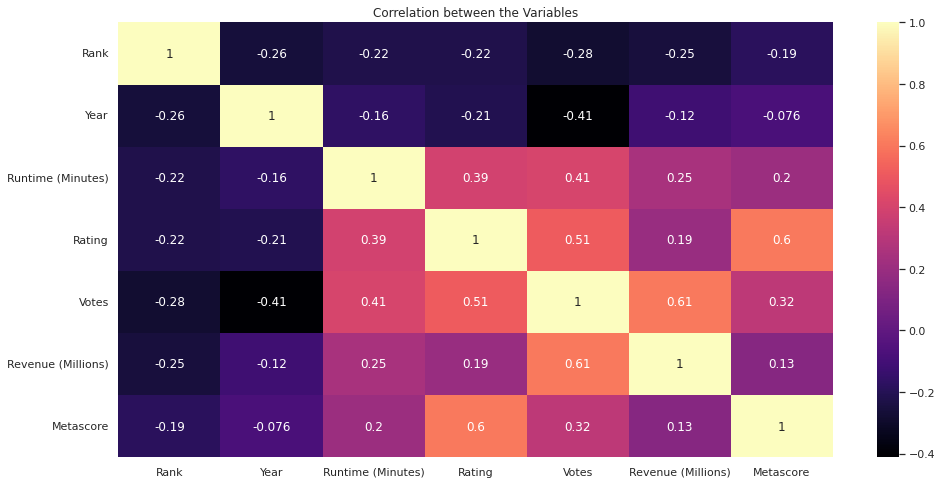

In [90]:
 # correlation between the attributes.

sns.heatmap(
    dff.corr(), annot=True, cmap="magma"
) 
plt.title('Correlation between the Variables')


**CORRELATION ANALYSIS:**

The graph above depicts the correlation between various features in the dataset. The heatmap shows a color matrix that represents the strength of the correlation between two variables.

A correlation coefficient, such as the Pearson correlation coefficient, can be used to calculate the correlation between two variables. This coefficient measures the linear relationship between two variables, with values ranging from -1 (perfect negative correlation) to 1 (perfect positive correlation) (perfect positive correlation). A value of 0 indicates that there is no correlation.

The correlation coefficients are represented as colors in a matrix in the heatmap above, with each variable plotted on both the x and y axes. The color of each cell in the matrix represents the strength of the correlation between the corresponding pair of variables, with a color scale ranging from low (e.g., light color) to high (e.g., dark color).

A correlation heatmap can assist in determining the relationships between variables in a dataset. It can be used to identify patterns and trends, as well as variables that are strongly correlated (either positively or negatively). This data can be used for exploratory data analysis as well as identifying potential predictors in statistical models.

Plotting all variables against each other to see if there is a relationship between them. It essentially tells the same story as the correlation matrix, but in a graphical format.


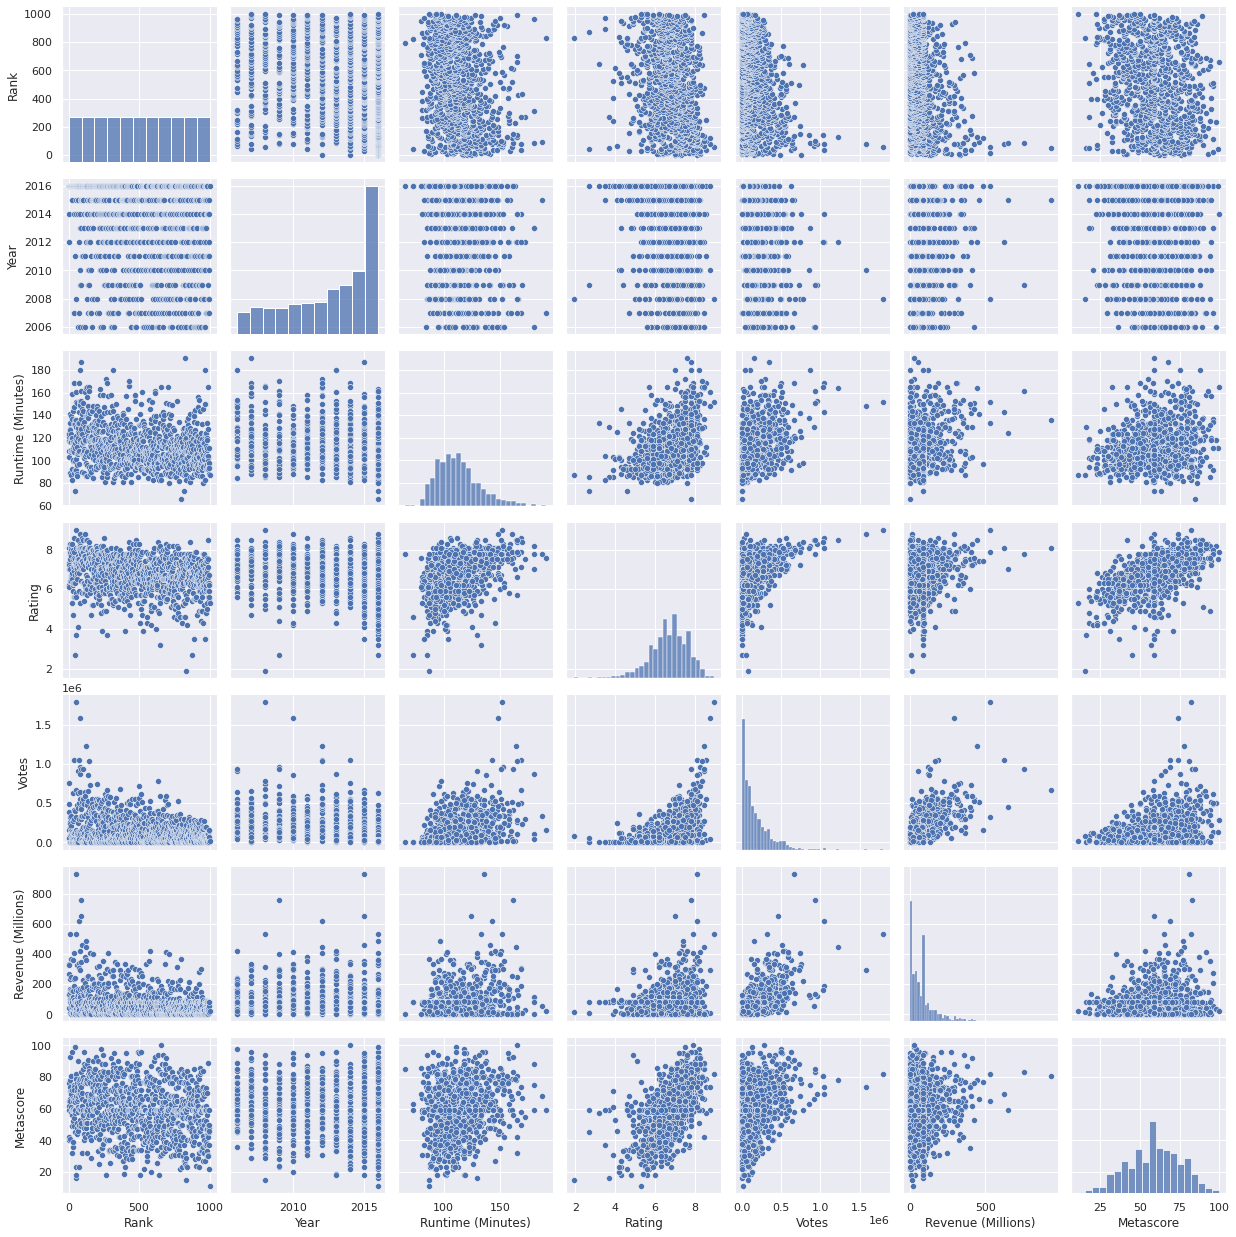

In [91]:
#Checking the Colinearity

sns.pairplot(
    dff
) 


/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


<Figure size 576x360 with 0 Axes>

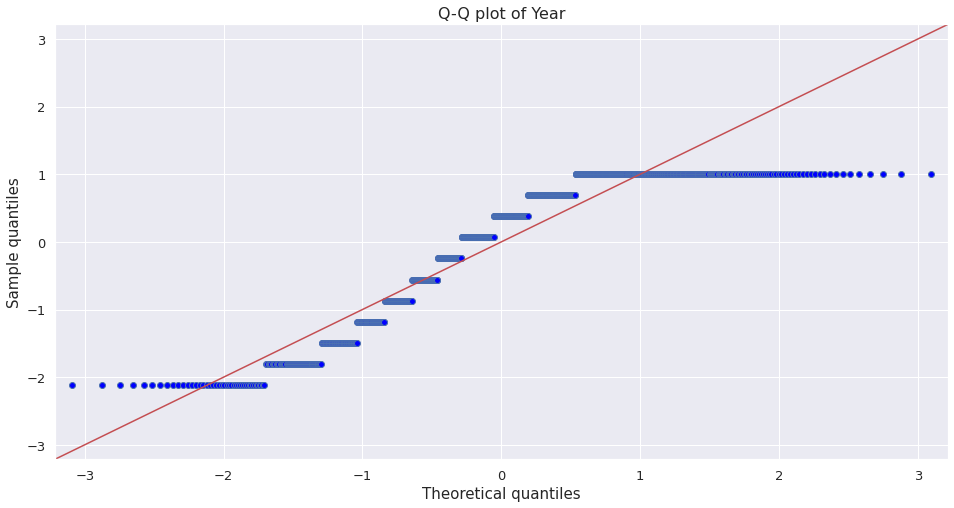

<Figure size 576x360 with 0 Axes>

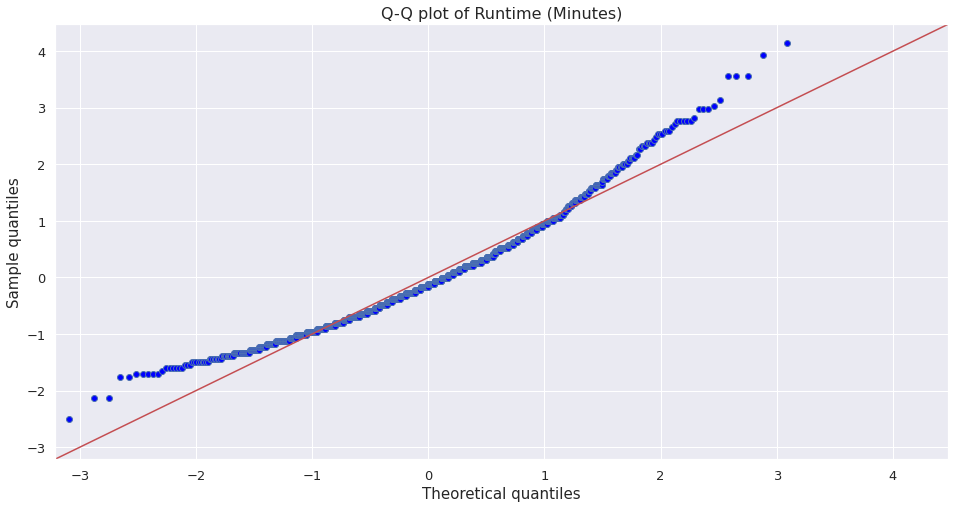

<Figure size 576x360 with 0 Axes>

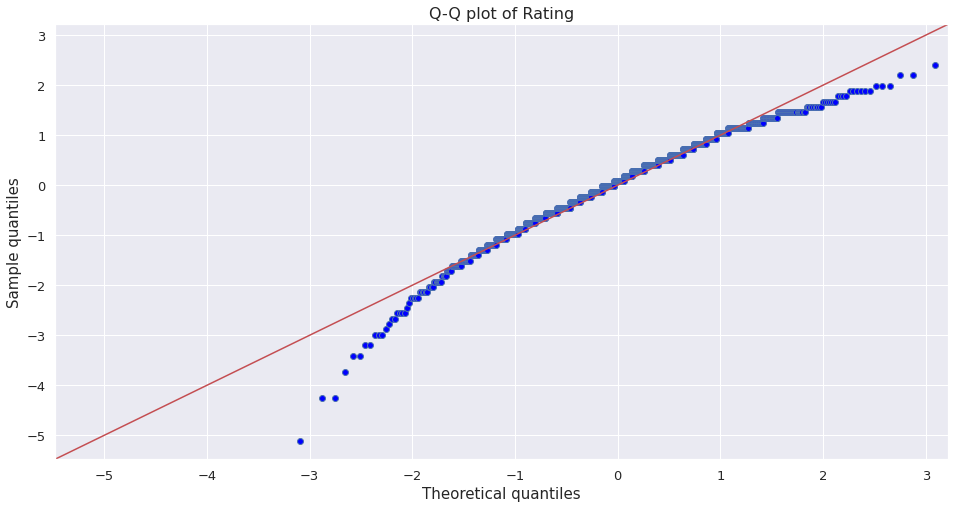

<Figure size 576x360 with 0 Axes>

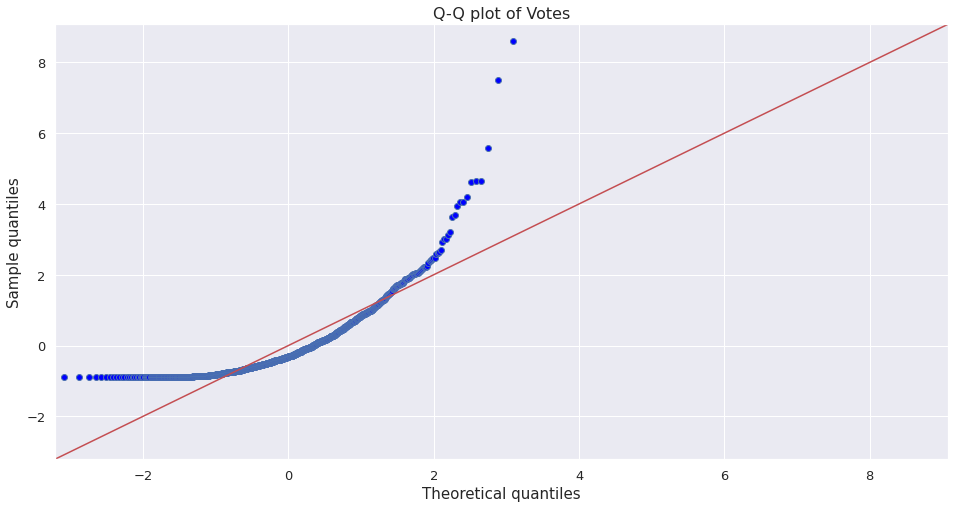

<Figure size 576x360 with 0 Axes>

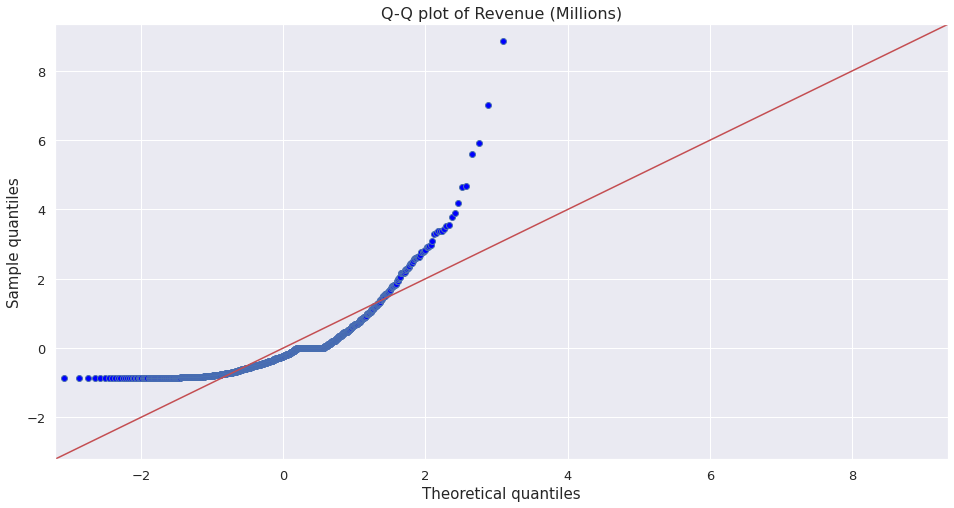

<Figure size 576x360 with 0 Axes>

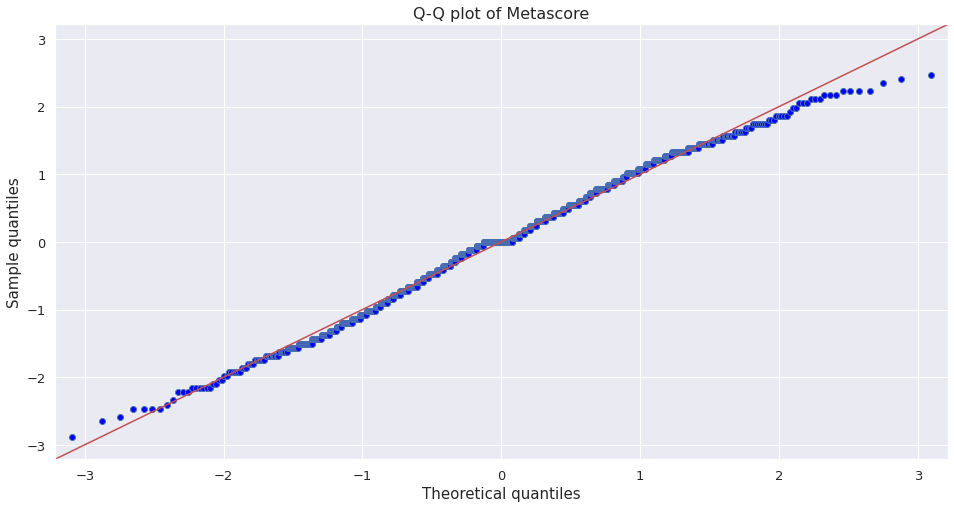

In [92]:
#The likely distributions of the numeric variables

from statsmodels.graphics.gofplots import qqplot
data_dist = dff[['Year','Runtime (Minutes)','Rating','Votes','Revenue (Millions)','Metascore']]
for c in data_dist.columns[:]:
  plt.figure(figsize=(8,5))
  fig=qqplot(data_dist[c],line='45',fit='True')
  plt.xticks(fontsize=13)
  plt.yticks(fontsize=13)
  plt.xlabel("Theoretical quantiles",fontsize=15)
  plt.ylabel("Sample quantiles",fontsize=15)
  plt.title("Q-Q plot of {}".format(c),fontsize=16)
  plt.grid(True)
  plt.show()

**GETTING STARTED WITH H2O:**

In [93]:
#Converting the Dataframe to H2O dataframe and proceed with AutoML

data = h2o.H2OFrame(
    dff
) 

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [94]:
# checking the dataypes 

data.types

{'Rank': 'int',
 'Title': 'string',
 'Genre': 'enum',
 'Description': 'string',
 'Director': 'enum',
 'Actors': 'string',
 'Year': 'int',
 'Runtime (Minutes)': 'int',
 'Rating': 'real',
 'Votes': 'int',
 'Revenue (Millions)': 'real',
 'Metascore': 'real'}

In [95]:
data.describe()


Rows:1000
Cols:12

,Rank,Title,Genre,Description,Director,Actors,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore
type,int,string,enum,string,enum,string,int,int,real,int,real,real
mins,1.0,NaN,,NaN,,NaN,2006.0,66.0,1.9,61.0,0.0,11.0
mean,500.5,NaN,,NaN,,NaN,2012.782999999999,113.17200000000001,6.723199999999997,169808.2550000001,82.95637614678903,58.98504273504268
maxs,1000.0,NaN,,NaN,,NaN,2016.0,191.0,9.0,1791916.0,936.63,100.0
sigma,288.8194360957494,NaN,,NaN,,NaN,3.2059615077522667,18.810908172288404,0.945428789277963,188762.6475182208,96.41204294886714,16.63485825330044
zeros,0,0,,0,,0,0,0,0,0,1,0
missing,0,0,0,0,0,0,0,0,0,0,0,0
0,1.0,Guardians of the Galaxy,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced to work together to stop a fanatical warrior from taking control of the universe.,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe Saldana",2014.0,121.0,8.1,757074.0,333.13,76.0
1,2.0,Prometheus,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a team finds a structure on a distant moon, but they soon realize they are not alone.",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fassbender, Charlize Theron",2012.0,124.0,7.0,485820.0,126.46,65.0
2,3.0,Split,"Horror,Thriller",Three girls are kidnapped by a man with a diagnosed 23 distinct personalities. They must try to escape before the apparent emergence of a frightful new 24th.,M. Night Shyamalan,"James McAvoy, Anya Taylor-Joy, Haley Lu Richardson, Jessica Sula",2016.0,117.0,7.3,157606.0,138.12,62.0


In [96]:
# Setting up the data split between training and test dataset.
pct_rows = 0.80 
data_train, data_test = data.split_frame([pct_rows])

In [97]:
print(data_train.shape)
print(data_test.shape)

(791, 12)
(209, 12)


In [98]:
data_train.head()

Rank,Title,Genre,Description,Director,Actors,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore
1,Guardians of the Galaxy,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced to work together to stop a fanatical warrior from taking control of the universe.,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe Saldana",2014,121,8.1,757074,333.13,76
3,Split,"Horror,Thriller",Three girls are kidnapped by a man with a diagnosed 23 distinct personalities. They must try to escape before the apparent emergence of a frightful new 24th.,M. Night Shyamalan,"James McAvoy, Anya Taylor-Joy, Haley Lu Richardson, Jessica Sula",2016,117,7.3,157606,138.12,62
5,Suicide Squad,"Action,Adventure,Fantasy",A secret government agency recruits some of the most dangerous incarcerated super-villains to form a defensive task force. Their first mission: save the world from the apocalypse.,David Ayer,"Will Smith, Jared Leto, Margot Robbie, Viola Davis",2016,123,6.2,393727,325.02,40
6,The Great Wall,"Action,Adventure,Fantasy",European mercenaries searching for black powder become embroiled in the defense of the Great Wall of China against a horde of monstrous creatures.,Yimou Zhang,"Matt Damon, Tian Jing, Willem Dafoe, Andy Lau",2016,103,6.1,56036,45.13,42
7,La La Land,"Comedy,Drama,Music",A jazz pianist falls for an aspiring actress in Los Angeles.,Damien Chazelle,"Ryan Gosling, Emma Stone, Rosemarie DeWitt, J.K. Simmons",2016,128,8.3,258682,151.06,93
8,Mindhorn,Comedy,"A has-been actor best known for playing the title character in the 1980s detective series ""Mindhorn"" must work with the police when a serial killer says that he will only speak with Detective Mindhorn, whom he believes to be a real person.",Sean Foley,"Essie Davis, Andrea Riseborough, Julian Barratt,Kenneth Branagh",2016,89,6.4,2490,82.9564,71
9,The Lost City of Z,"Action,Adventure,Biography","A true-life drama, centering on British explorer Col. Percival Fawcett, who disappeared while searching for a mysterious city in the Amazon in the 1920s.",James Gray,"Charlie Hunnam, Robert Pattinson, Sienna Miller, Tom Holland",2016,141,7.1,7188,8.01,78
10,Passengers,"Adventure,Drama,Romance","A spacecraft traveling to a distant colony planet and transporting thousands of people has a malfunction in its sleep chambers. As a result, two passengers are awakened 90 years early.",Morten Tyldum,"Jennifer Lawrence, Chris Pratt, Michael Sheen,Laurence Fishburne",2016,116,7,192177,100.01,41
11,Fantastic Beasts and Where to Find Them,"Adventure,Family,Fantasy",The adventures of writer Newt Scamander in New York's secret community of witches and wizards seventy years before Harry Potter reads his book in school.,David Yates,"Eddie Redmayne, Katherine Waterston, Alison Sudol,Dan Fogler",2016,133,7.5,232072,234.02,66
12,Hidden Figures,"Biography,Drama,History",The story of a team of female African-American mathematicians who served a vital role in NASA during the early years of the U.S. space program.,Theodore Melfi,"Taraji P. Henson, Octavia Spencer, Janelle Monáe,Kevin Costner",2016,127,7.8,93103,169.27,74


In [99]:
X = data.columns
print(X)

['Rank', 'Title', 'Genre', 'Description', 'Director', 'Actors', 'Year', 'Runtime (Minutes)', 'Rating', 'Votes', 'Revenue (Millions)', 'Metascore']


In [100]:
# Set target and predictor variables
y = "Votes"
X.remove(y)  # Removing the result frm our predictors data
print(X)

['Rank', 'Title', 'Genre', 'Description', 'Director', 'Actors', 'Year', 'Runtime (Minutes)', 'Rating', 'Revenue (Millions)', 'Metascore']


In [101]:
aml = H2OAutoML(max_runtime_secs=run_time, seed=1)  # Setting of AutoML


In [102]:
aml.train(x=X, y=y, training_frame=data_train)  # Trainig the dataset on different models

AutoML progress: |
01:28:01.481: _train param, Dropping bad and constant columns: [Title, Actors, Description]

█
01:28:05.469: _train param, Dropping bad and constant columns: [Title, Actors, Description]

█
01:28:07.193: _train param, Dropping bad and constant columns: [Title, Actors, Description]

██
01:28:12.431: _train param, Dropping unused columns: [Title, Actors, Description]
01:28:12.882: _train param, Dropping bad and constant columns: [Title, Actors, Description]


01:28:14.943: _train param, Dropping bad and constant columns: [Title, Actors, Description]

█████
01:28:30.528: _train param, Dropping bad and constant columns: [Title, Actors, Description]

█
01:28:33.356: _train param, Dropping bad and constant columns: [Title, Actors, Description]


01:28:36.579: _train param, Dropping bad and constant columns: [Title, Actors, Description]

██
01:28:41.159: _train param, Dropping unused columns: [Title, Actors, Description]
01:28:41.464: _train param, Dropping unused columns: 

key,value
Stacking strategy,cross_validation
Number of base models (used / total),4/6
# GBM base models (used / total),1/1
# XGBoost base models (used / total),1/1
# DRF base models (used / total),1/2
# DeepLearning base models (used / total),1/1
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5


**UNDERTSANDING THE PARAMETERS:**

MSE (Mean Squared Error): The MSE calculates the average squared difference between predicted and actual values. It is computed by averaging the squared differences between predicted and actual values. It is a widely used metric for assessing the accuracy of regression models.

The Root Mean Squared Error (RMSE) is the square root of the MSE and is a popular metric for assessing the accuracy of regression models. The RMSE is a measurement of how well the model predicts actual values.

Mean Absolute Error (MAE): The MAE is a metric that measures the average absolute difference between predicted and actual values. It is computed by averaging the absolute differences between predicted and actual values. It is a widely used metric for assessing the accuracy of regression models.

Root Mean Squared Logarithmic Error (RMSLE): The RMSLE is a variation of the RMSE that is used in regression models with a wide range of values for the target variable. It is calculated by taking the square root of the average of the squared differences between the predicted and actual values' logarithms.

Mean Residual Deviance: The Mean Residual Deviance is a measure of a regression model's goodness of fit. It computes the average difference between predicted and actual values, normalized by the model's degrees of freedom.

R-squared (R2): R-squared is a metric that measures how well the model fits the data. The proportion of the variance explained by the independent variables in the dependent variable. A value of 1 indicates that the model explains all of the data variability, while a value of 0 indicates that the model explains none of the variability.

Null Degrees of Freedom: This is the number of observations in the dataset minus one. It denotes the number of observations in the dataset that are free to vary, given the number of parameters in the model.

Residual Degrees of Freedom: The number of observations in the dataset less the number of parameters in the model equals the Residual Degrees of Freedom. It represents the number of observations in the dataset that are free to vary after accounting for the number of model parameters.

The Null Deviance is the deviation from the null model, which is a model with no independent variables. It denotes the variance in the dependent variable that is unaccounted for by the independent variables.

The residual deviation is the model's deviation after accounting for the independent variables. It denotes the variance in the dependent variable that is unaccounted for by the independent variables.

Akaike Information Criterion (AIC): The AIC is a model quality metric that takes model complexity into account. It is calculated as the model's negative log-likelihood multiplied by twice the number of parameters. The AIC can be used to compare model quality, with lower values indicating higher quality.




In [103]:
# the performances of different models

print(
    aml.leaderboard
)

model_id                                                   rmse          mse      mae    rmsle    mean_residual_deviance
StackedEnsemble_BestOfFamily_4_AutoML_1_20230301_12801  74723.3  5.58358e+09  50366.2      nan               5.58358e+09
XGBoost_grid_1_AutoML_1_20230301_12801_model_13         76095.6  5.79055e+09  50294.8      nan               5.79055e+09
StackedEnsemble_BestOfFamily_3_AutoML_1_20230301_12801  79518.7  6.32322e+09  53489        nan               6.32322e+09
XGBoost_grid_1_AutoML_1_20230301_12801_model_23         79779.5  6.36477e+09  52489.4      nan               6.36477e+09
StackedEnsemble_AllModels_2_AutoML_1_20230301_12801     80280.2  6.44492e+09  53354.7      nan               6.44492e+09
StackedEnsemble_AllModels_3_AutoML_1_20230301_12801     80950.1  6.55292e+09  51396.8      nan               6.55292e+09
XGBoost_grid_1_AutoML_1_20230301_12801_model_29         82840.8  6.8626e+09   53981.1      nan               6.8626e+09
StackedEnsemble_BestOfFamily_2_Au

**IMPORTANCE OF VARIABLES:**

In [104]:
model_index = 0
glm_index = 0
glm_model = ""
aml_leaderboard_df = aml.leaderboard.as_data_frame()
models_dict = {}
for m in aml_leaderboard_df["model_id"]:
    models_dict[m] = model_index
    if "StackedEnsemble" not in m:
        break
    model_index = model_index + 1

for m in aml_leaderboard_df["model_id"]:
    if "GLM" in m:
        models_dict[m] = glm_index
        break
    glm_index = glm_index + 1
models_dict

{'StackedEnsemble_BestOfFamily_4_AutoML_1_20230301_12801': 0,
 'XGBoost_grid_1_AutoML_1_20230301_12801_model_13': 1,
 'GLM_1_AutoML_1_20230301_12801': 72}

In [105]:
print(model_index)
best_model = h2o.get_model(aml.leaderboard[model_index, "model_id"])


1


In [106]:
best_model.algo


'xgboost'

XGBoost is a popular machine learning algorithm that can be used to train multiple models for different purposes.

In [107]:
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
import matplotlib.cbook

warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)


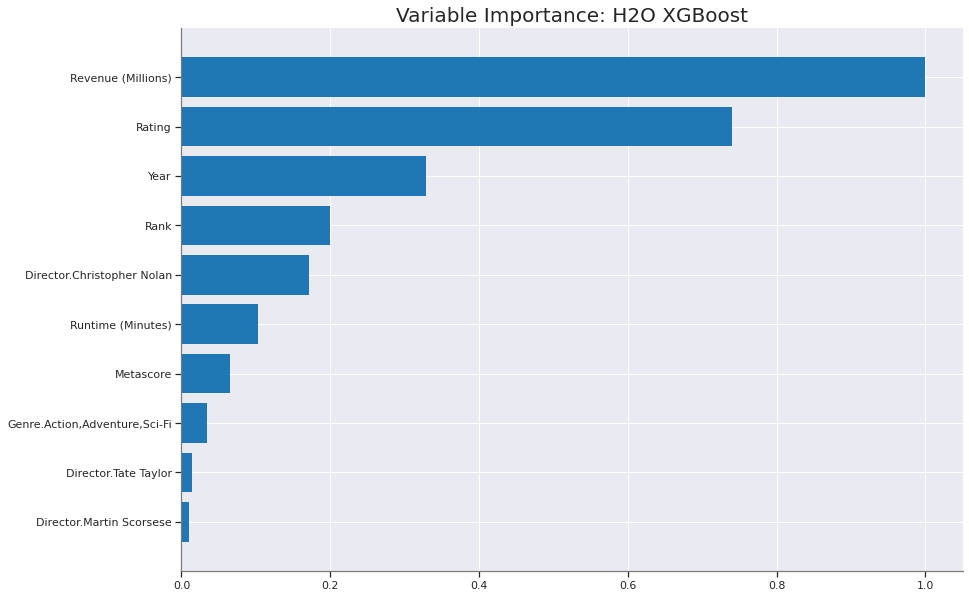

<Figure size 432x288 with 0 Axes>

In [108]:
if best_model.algo in [
    "gbm",
    "drf",
    "xrt",
    "xgboost",
]:  # Importance of all the variables in GBM algorithm.
    best_model.varimp_plot()

The above graph is a variable Importance Graph on the H20's Distributed Random Forest Model

We can conclude that Revenue (Millions) is the Most Important Variable among all with importance.

In [109]:
print(best_model.rmse(train=True))


25049.640661494384


In [110]:
def model_performance_stats(perf):
    d = {}
    try:
        d["mse"] = perf.mse()
    except:
        pass
    try:
        d["rmse"] = perf.rmse()
    except:
        pass
    try:
        d["null_degrees_of_freedom"] = perf.null_degrees_of_freedom()
    except:
        pass
    try:
        d["residual_degrees_of_freedom"] = perf.residual_degrees_of_freedom()
    except:
        pass
    try:
        d["residual_deviance"] = perf.residual_deviance()
    except:
        pass
    try:
        d["null_deviance"] = perf.null_deviance()
    except:
        pass
    try:
        d["aic"] = perf.aic()
    except:
        pass
    try:
        d["logloss"] = perf.logloss()
    except:
        pass
    try:
        d["auc"] = perf.auc()
    except:
        pass
    try:
        d["gini"] = perf.gini()
    except:
        pass
    return d


In [111]:
mod_perf = best_model.model_performance(data_test)
stats_test = {}
stats_test = model_performance_stats(mod_perf)
stats_test


{'mse': 6093853719.218987,
 'rmse': 78063.13931183518,
 'null_degrees_of_freedom': None,
 'residual_degrees_of_freedom': None,
 'residual_deviance': None,
 'null_deviance': None}

In [112]:
predictions = best_model.predict(data_test)


xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


In [113]:
y_pred = h2o.as_list(
    predictions
)  # Predictions on Test Dataset using the best model from the leaderboard.
print(y_pred)

           predict
0    318981.375000
1    237760.109375
2     65659.195312
3     63803.500000
4     96715.187500
..             ...
204   12566.104492
205   35342.820312
206   79594.445312
207   48715.750000
208   82234.609375

[209 rows x 1 columns]


In [114]:
y_test = h2o.as_list(data_test[y])  # Real Answers
y_test

,Votes
0,485820
1,60545
2,38552
3,66540
4,48123
...,...
204,1810
205,92378
206,108544
207,21405


In [115]:
print(X)

['Rank', 'Title', 'Genre', 'Description', 'Director', 'Actors', 'Year', 'Runtime (Minutes)', 'Rating', 'Revenue (Millions)', 'Metascore']


**REGULARIZATION:**

GLM models with Ridge and Lasso regularization techniques are commonly 
used in linear regression to prevent overfitting and improve the model's ability to generalize to new data. Ridge regularization works by adding a penalty term to the least-squares objective function of the linear regression model that is proportional to the square of the magnitude of the coefficients. 
This penalty term helps to shrink the coefficients towards zero, thereby reducing the effect of correlated input variables and improving the model's performance. The strength of the penalty is controlled by a hyperparameter that needs to be tuned to optimize performance. Lasso regularization, on the other hand, adds a penalty term proportional to the absolute value of the coefficients, which can set some coefficients to exactly zero and effectively remove irrelevant variables from the model. The main difference between Ridge and Lasso regularization is the type of penalty function used, with Ridge using L2 regularization and Lasso using L1 regularization. The choice between these techniques depends on the specific problem and input variables.




In [116]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

params = {"family": "gaussian", "nfolds": 5}

wine_glm = H2OGeneralizedLinearEstimator(lambda_=0, compute_p_values=True, **params)
wine_glm_regularization_ridge = H2OGeneralizedLinearEstimator(alpha=0, **params)
wine_glm_regularization_lasso = H2OGeneralizedLinearEstimator(alpha=1, **params)
wine_glm_regularization_lamba_search = H2OGeneralizedLinearEstimator(lambda_search=True)


This code defines several H2O GLM models with a common set of hyperparameters by first creating a dictionary params that contains the common parameters, including the family type (gaussian) and the number of cross-validation folds (nfolds) set to 5.

The H2OGeneralizedLinearEstimator function is then used to create four different GLM models, each with a slightly different set of hyperparameters:

wine_glm is a GLM model with Elastic Net regularization, set by the lambda_=0 parameter and with compute_p_values set to True. The **params syntax at the end of the line passes the dictionary of common parameters to the H2OGeneralizedLinearEstimator function, which will apply those parameters to this model.

wine_glm_regularization_ridge is a GLM model with Ridge regularization, set by the alpha=0 parameter. It also uses the common parameters defined in the params dictionary.

wine_glm_regularization_lasso is a GLM model with LASSO regularization, set by the alpha=1 parameter. It also uses the common parameters defined in the params dictionary.

wine_glm_regularization_lamba_search is a GLM model that uses lambda search to automatically determine the optimal value for the regularization parameter lambda. It does not specify any of the common hyperparameters, so they will default to their H2O library defaults.

By using a dictionary to define the common hyperparameters, the code simplifies the process of creating multiple similar models with slightly different hyperparameters, reducing code duplication and making the code easier to read and maintain.





In [117]:
data.isna().sum()

0.0

In [118]:
data.describe()

Rows:1000
Cols:12

,Rank,Title,Genre,Description,Director,Actors,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore
type,int,string,enum,string,enum,string,int,int,real,int,real,real
mins,1.0,NaN,,NaN,,NaN,2006.0,66.0,1.9,61.0,0.0,11.0
mean,500.5,NaN,,NaN,,NaN,2012.782999999999,113.17200000000001,6.723199999999997,169808.2550000001,82.95637614678903,58.98504273504268
maxs,1000.0,NaN,,NaN,,NaN,2016.0,191.0,9.0,1791916.0,936.63,100.0
sigma,288.8194360957494,NaN,,NaN,,NaN,3.2059615077522667,18.810908172288404,0.945428789277963,188762.6475182208,96.41204294886714,16.63485825330044
zeros,0,0,,0,,0,0,0,0,0,1,0
missing,0,0,0,0,0,0,0,0,0,0,0,0
0,1.0,Guardians of the Galaxy,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced to work together to stop a fanatical warrior from taking control of the universe.,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe Saldana",2014.0,121.0,8.1,757074.0,333.13,76.0
1,2.0,Prometheus,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a team finds a structure on a distant moon, but they soon realize they are not alone.",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fassbender, Charlize Theron",2012.0,124.0,7.0,485820.0,126.46,65.0
2,3.0,Split,"Horror,Thriller",Three girls are kidnapped by a man with a diagnosed 23 distinct personalities. They must try to escape before the apparent emergence of a frightful new 24th.,M. Night Shyamalan,"James McAvoy, Anya Taylor-Joy, Haley Lu Richardson, Jessica Sula",2016.0,117.0,7.3,157606.0,138.12,62.0


In [119]:
data=data[["Rank","Year","Rating","Votes","Revenue (Millions)","Metascore","Runtime (Minutes)"]]


In [120]:
train,test = data.split_frame([.9])


In [121]:
#  Set response variable and your choice of predictor variables
myY = "Revenue (Millions)"
myX = ["Rank","Year","Rating","Votes","Metascore","Runtime (Minutes)"]

In [122]:
# Build simple GLM model
data_glm = H2OGeneralizedLinearEstimator(family="gaussian", standardize=True)
data_glm.train(x               =myX,
               y               =myY,
               training_frame  =train,
               validation_frame=test)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1677634021016_25


GLM Model: summary
    family    link      regularization                               number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  -------------------------------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    gaussian  identity  Elastic Net (alpha = 0.5, lambda = 0.1172 )  6                             6                              1                       py_421_sid_a82c

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 5539.960546354639
RMSE: 74.43091122883447
MAE: 51.36754758430943
RMSLE: 1.4237939172107115
Mean Residual Deviance: 5539.960546354639
R^2: 0.4063086164216889
Null degrees of freedom: 903
Residual degrees of freedom: 897
Null deviance: 8435568.499781048
Residual deviance: 5008124.333904593
AIC: 10373.688230973927

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 5083.827721345246
RMSE: 71.30096578129391
MAE: 49.81604767936563
RMSLE: 1.5758889031888308
Mean Residual Deviance: 5083.827721345246
R^2: 0.41385133797406193
Null degrees of freedom: 95
Residual degrees of freedom: 89
Null deviance: 852306.7970564826
Residual deviance: 488047.4612491436
AIC: 1107.682893923752

Scoring History: 
    timestamp            duration    iterations    negative_log_likelihood    objective          training_rmse      training_deviance    training_mae       training_r2         validation_rmse    validation_deviance    validation_mae     validation_r2
--  -------------------  ----------  ------------  -------------------------  -----------------  -----------------  -------------------  -----------------  ------------------  -----------------  ---------------------  -----------------  -------------------
    2023-03-01 01:31:49  0.000 sec   0             8435568.530416982          9331.381117717901
    2023-03-01 01:31:49  0.017 sec   1                                                           74.43091122883447  5539.960546354639    51.36754758430943  0.4063086164216889  71.30096578129391  5083.827721345246      49.81604767936563  0.41385133797406193

Variable Importances: 
variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  ------------
Votes              62.3271                1                    0.65748
Rating             12.9208                0.207307             0.1363
Year               9.93716                0.159436             0.104826
Rank               6.05233                0.0971059            0.0638452
Runtime (Minutes)  3.4272                 0.0549873            0.0361531
Metascore          0.132331               0.00212317           0.00139594

[tips]
Use `model.explain()` to inspect the model.
--
Use `h2o.display.toggle_user_tips()` to switch on/off this section.

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

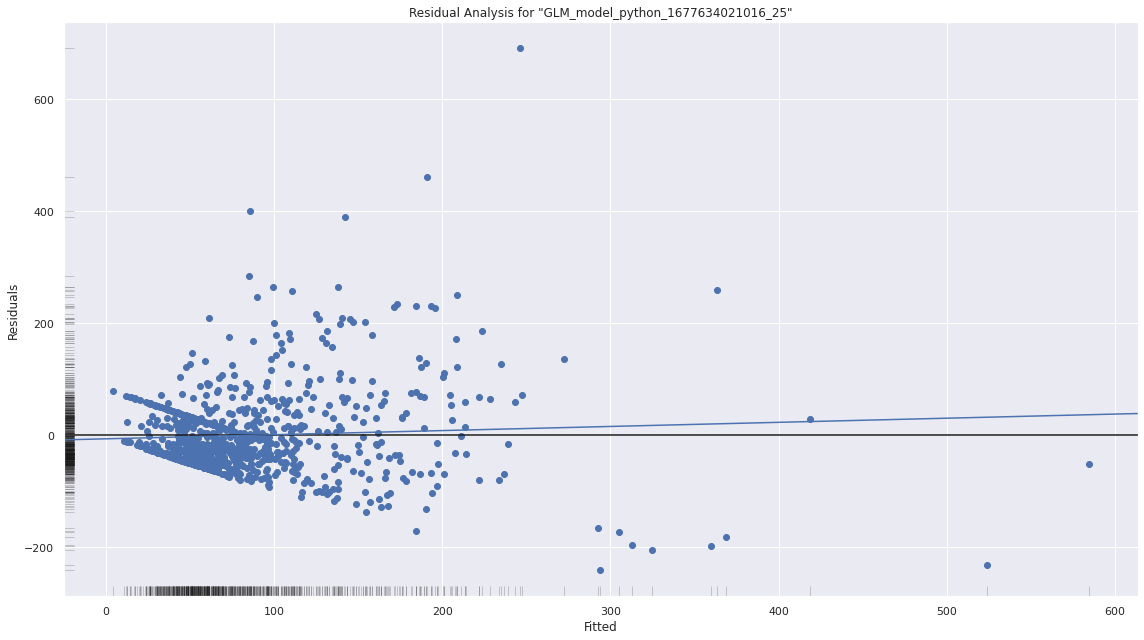

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

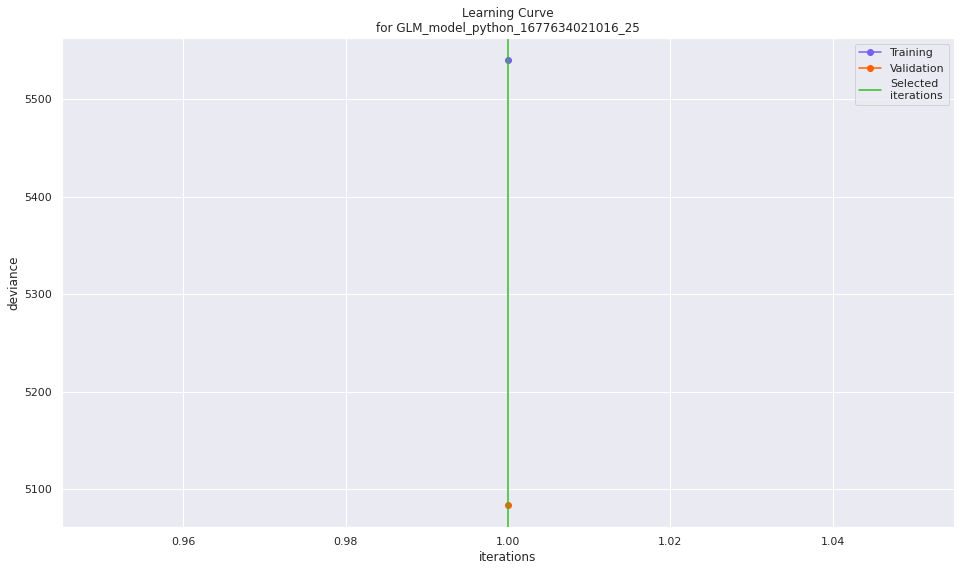

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

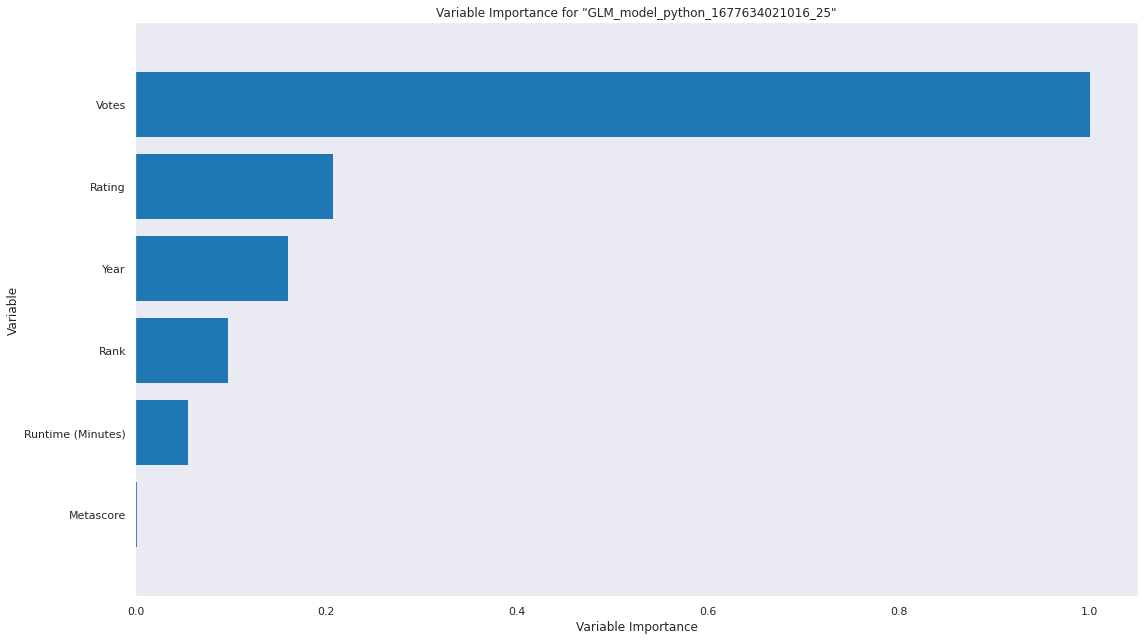

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

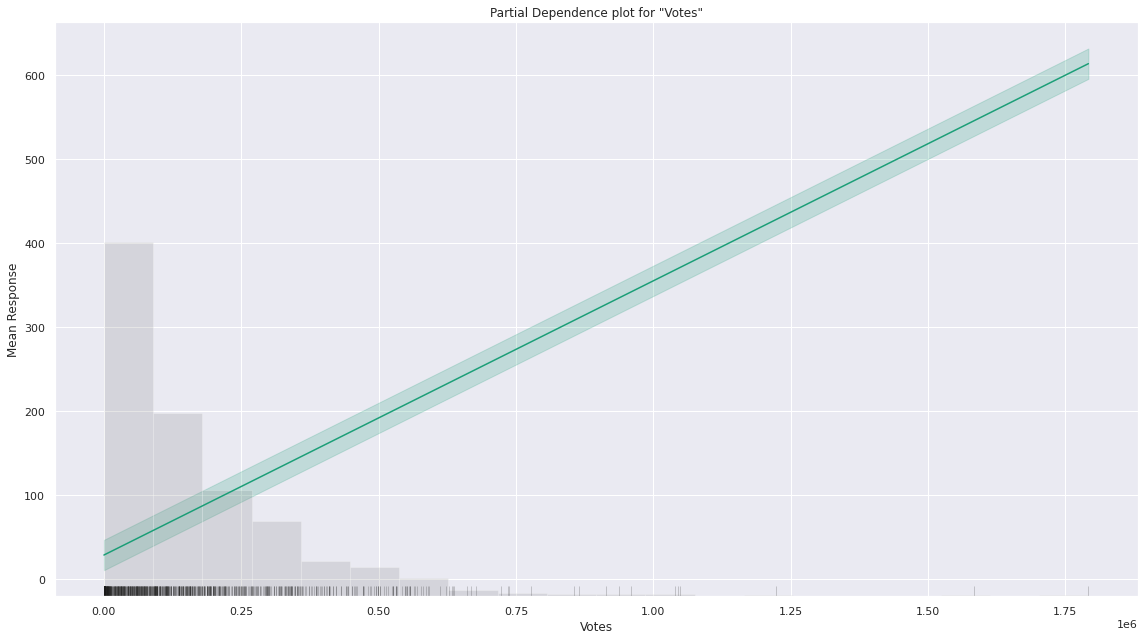

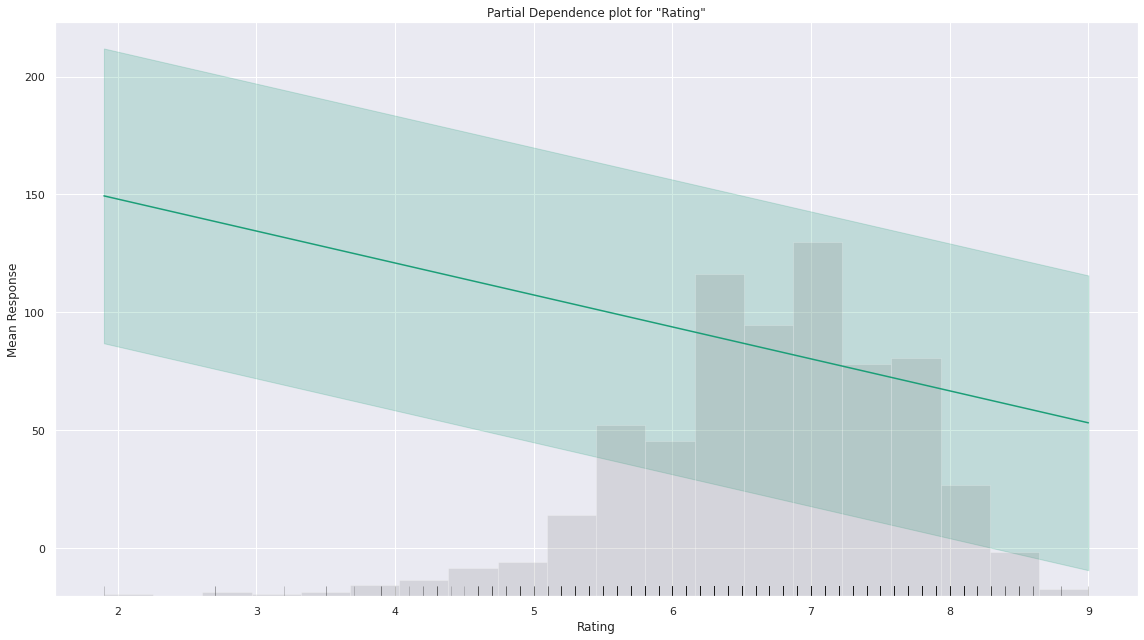

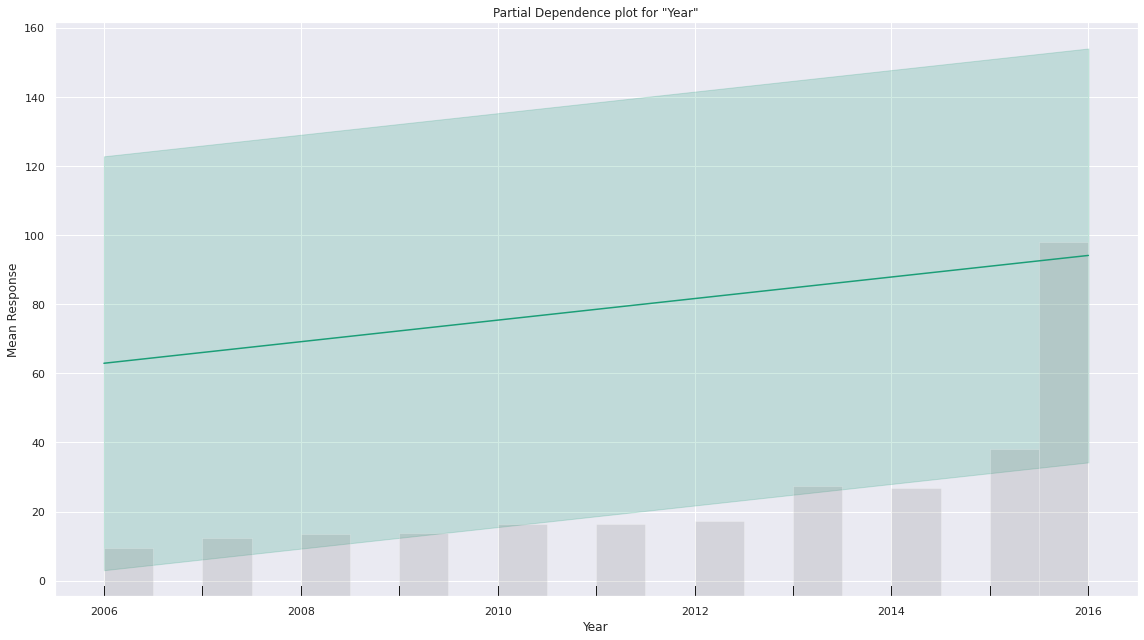

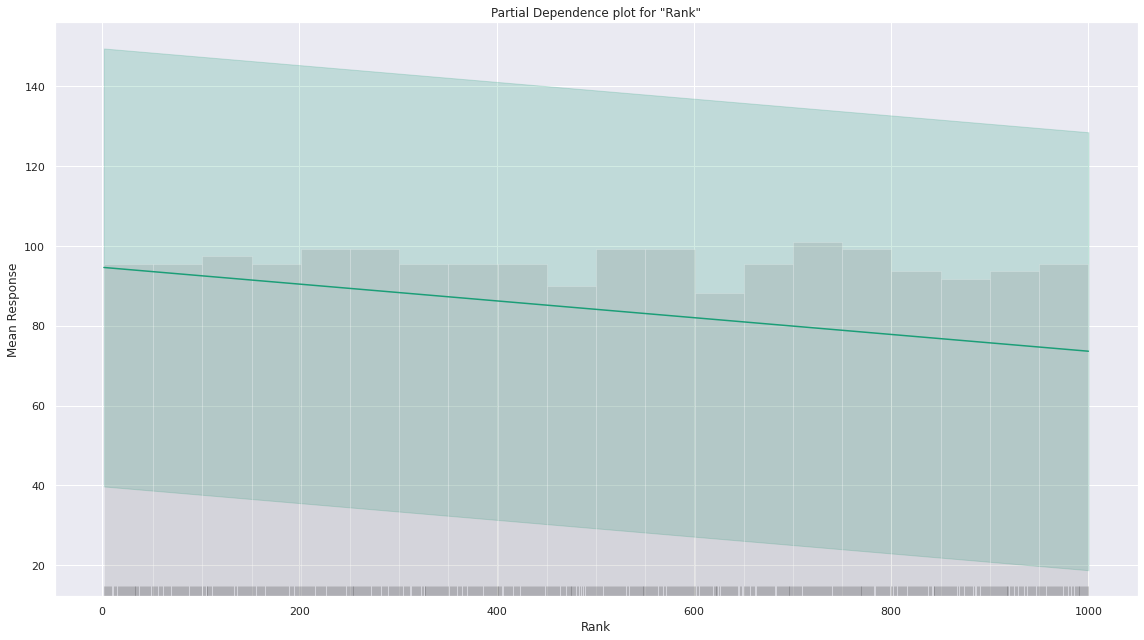

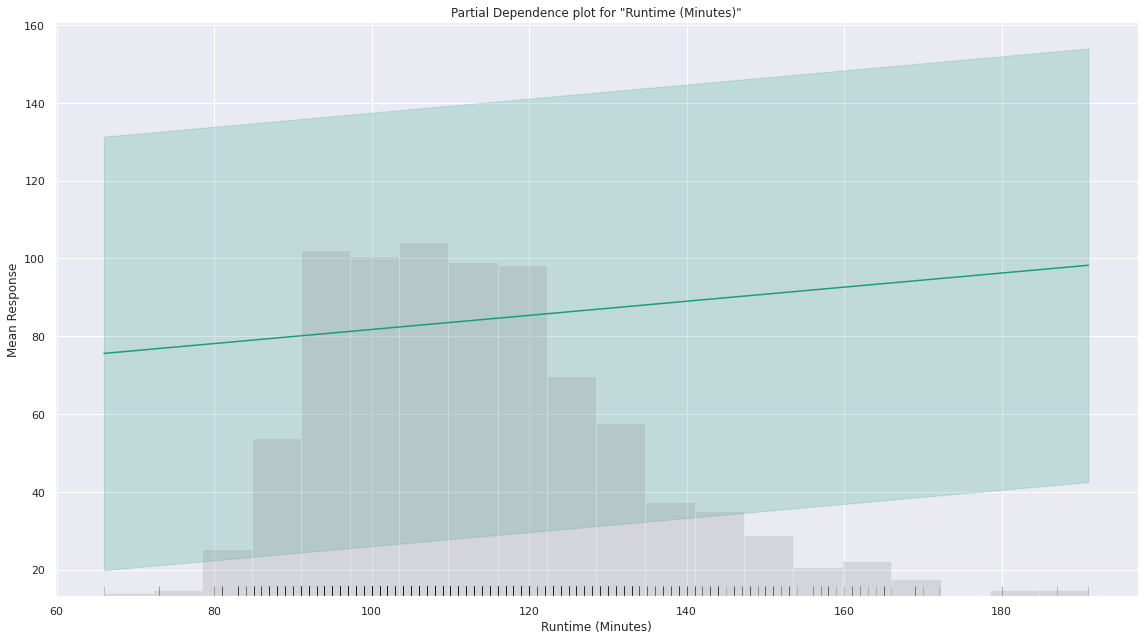

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

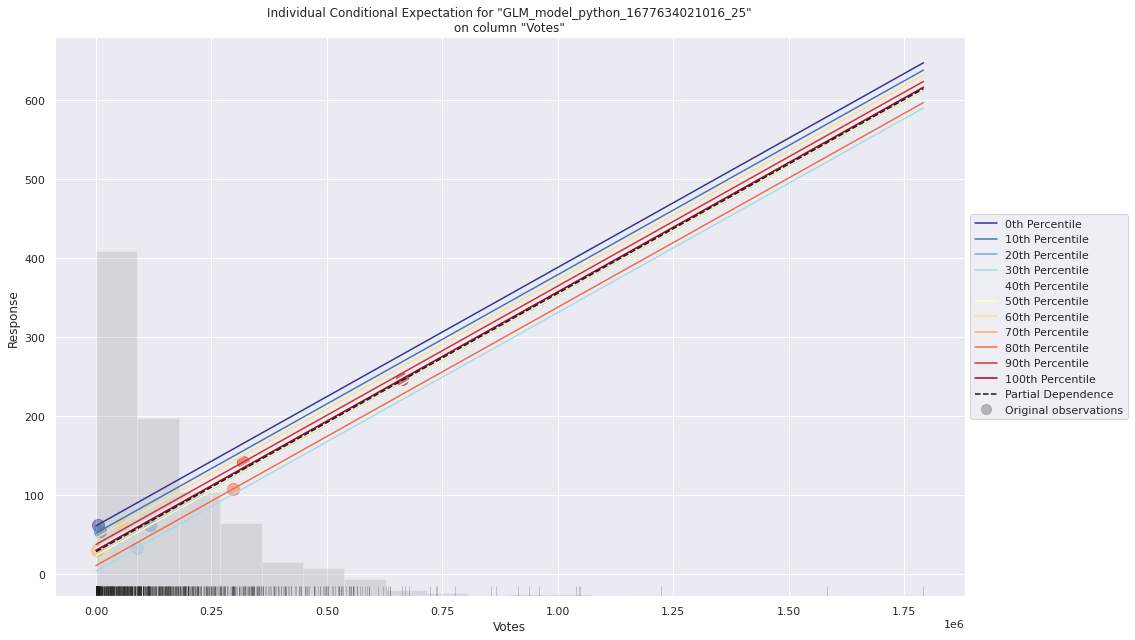

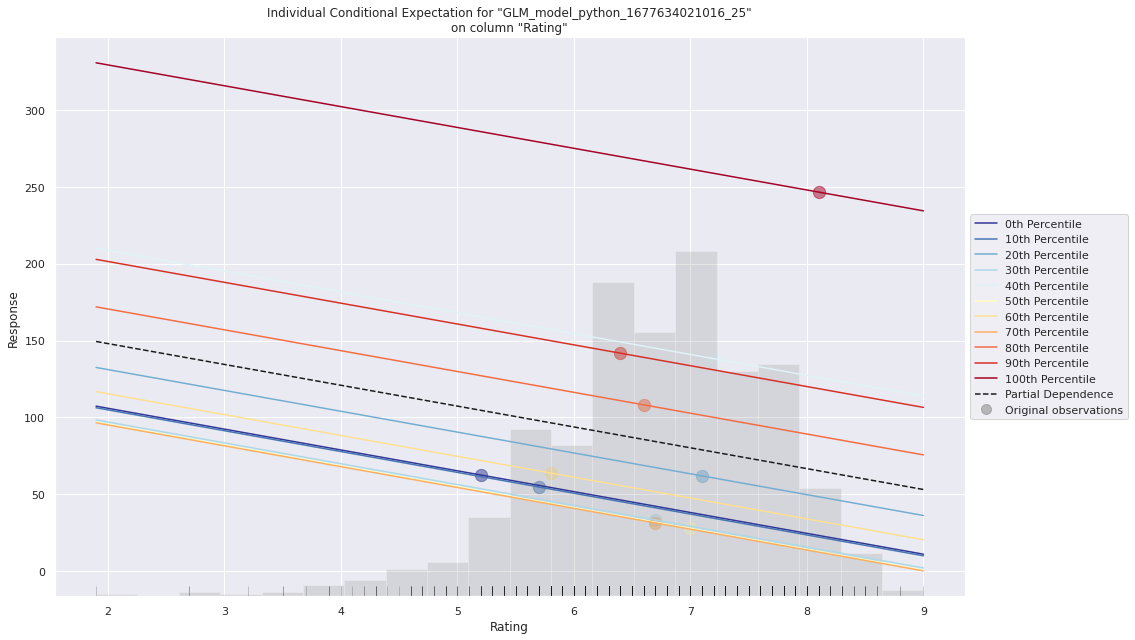

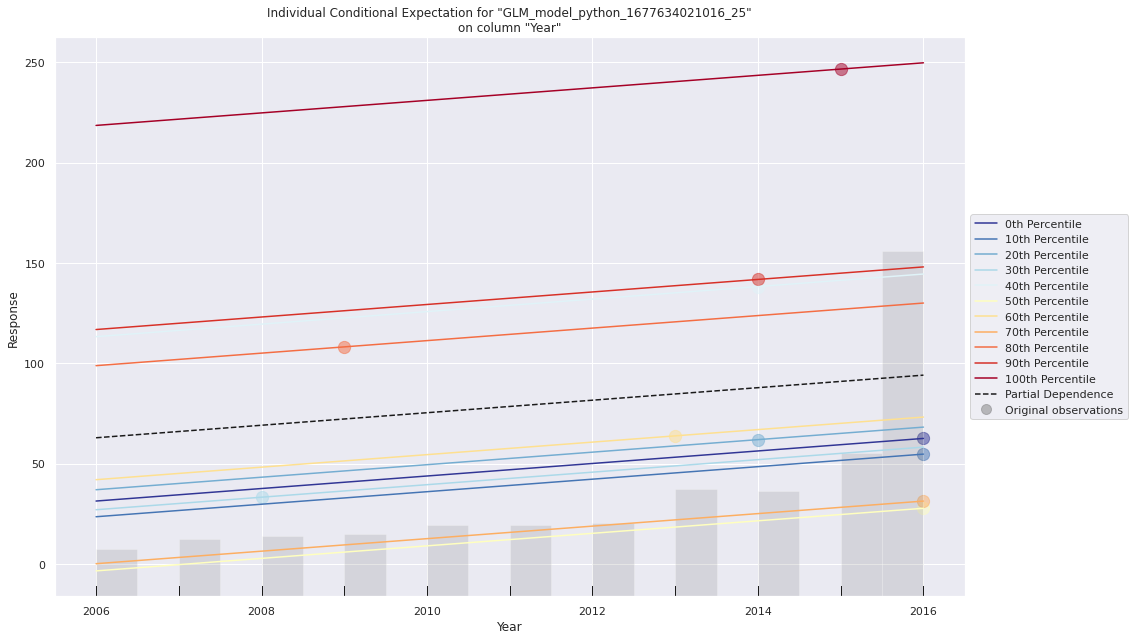

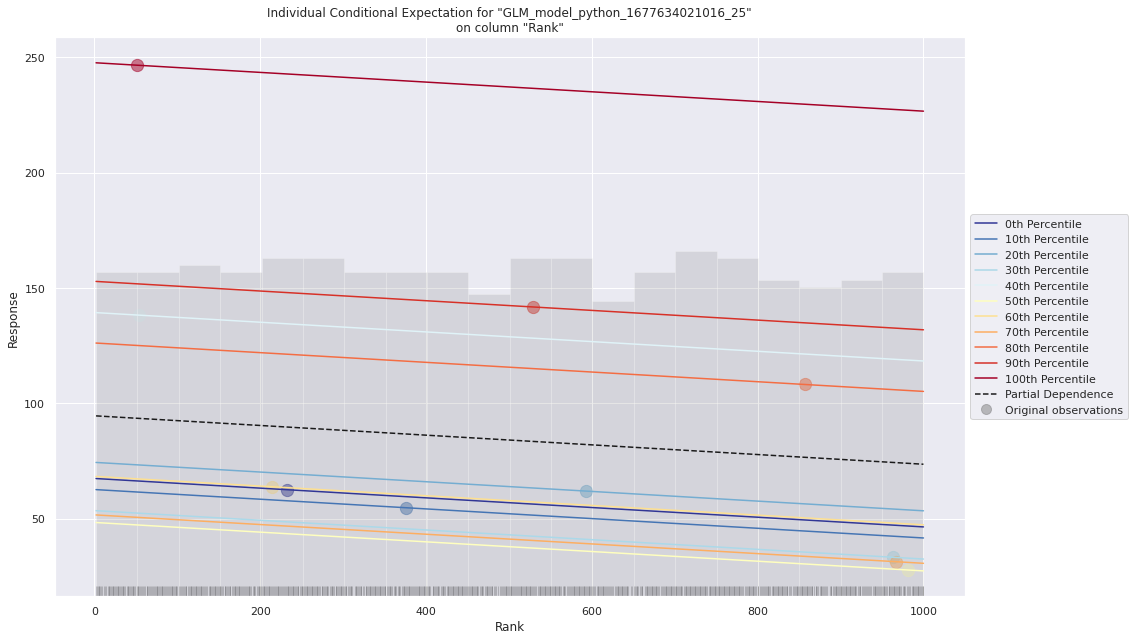

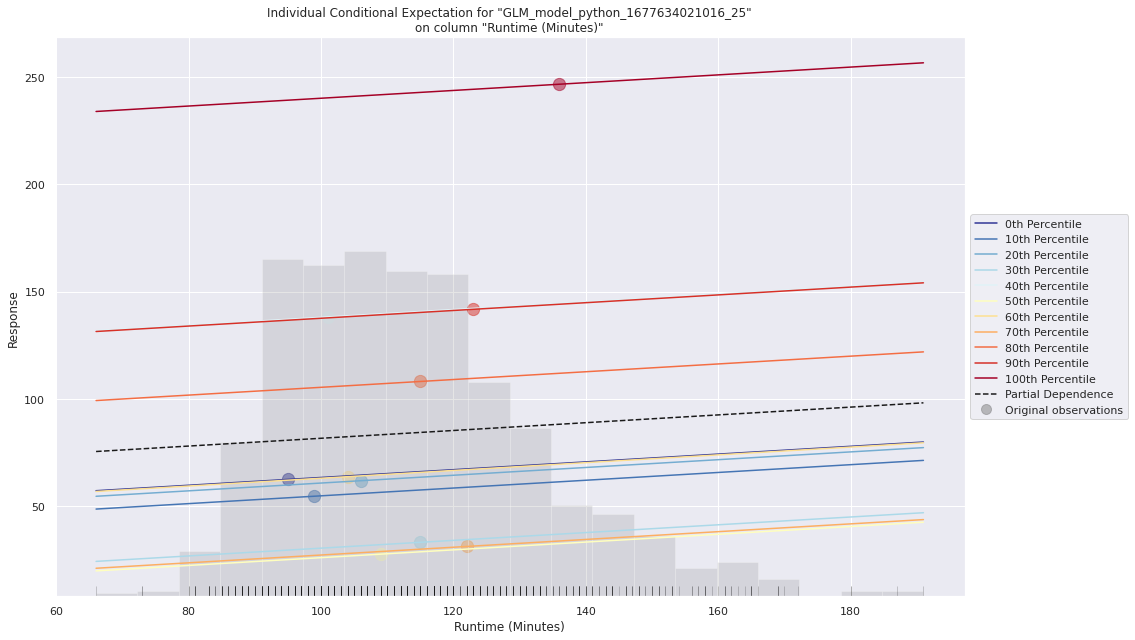

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

In [123]:
data_glm.explain(train[1:1000,:])


**GBM Model**
Gradient Boosting Machine (for Regression and Classification) is a forward learning ensemble method. The guiding heuristic is that good predictive results can be obtained through increasingly refined approximations. H2O’s GBM sequentially builds regression trees on all the features of the dataset in a fully distributed way - each tree is built in parallel.

In [124]:
# Building a simple GBM model

from h2o.estimators import H2OGradientBoostingEstimator

# Initialize the GBM model with hyperparameters
model_gbm = H2OGradientBoostingEstimator(
                balance_classes=True,
                ntrees=1000,
                max_depth=1,
                learn_rate=0.1,
                min_rows=2)

# Train the GBM model on the training data
model_gbm.train(x=myX,
                y=myY,
                training_frame=train,
                validation_frame=test)


gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
,1000.0,1000.0,84811.0,1.0,1.0,1.0,2.0,2.0,2.0
,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2023-03-01 01:33:00,0.006 sec,0.0,96.5990739,64.1241546,9331.3810838,94.2241784,59.5705987,8878.1958027
,2023-03-01 01:33:00,0.024 sec,1.0,93.7468595,61.9335766,8788.4736745,92.2207571,58.2338884,8504.6680448
,2023-03-01 01:33:00,0.037 sec,2.0,91.3589117,60.4181140,8346.4507503,90.5942291,57.3213811,8207.3143428
,2023-03-01 01:33:00,0.043 sec,3.0,89.2890257,59.0017184,7972.5301163,89.0511985,56.2997051,7930.1159591
,2023-03-01 01:33:00,0.051 sec,4.0,87.5748954,57.9107031,7669.3623087,87.9659306,55.7116875,7738.0049520
,2023-03-01 01:33:00,0.058 sec,5.0,86.1205156,57.0396252,7416.7432143,87.0891716,55.0141837,7584.5238170
,2023-03-01 01:33:00,0.063 sec,6.0,84.8211666,56.3828170,7194.6302980,85.9481021,54.6314895,7387.0762525
,2023-03-01 01:33:00,0.073 sec,7.0,83.6725548,55.7308992,7001.0964283,85.1650199,54.0539678,7253.0806205


# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

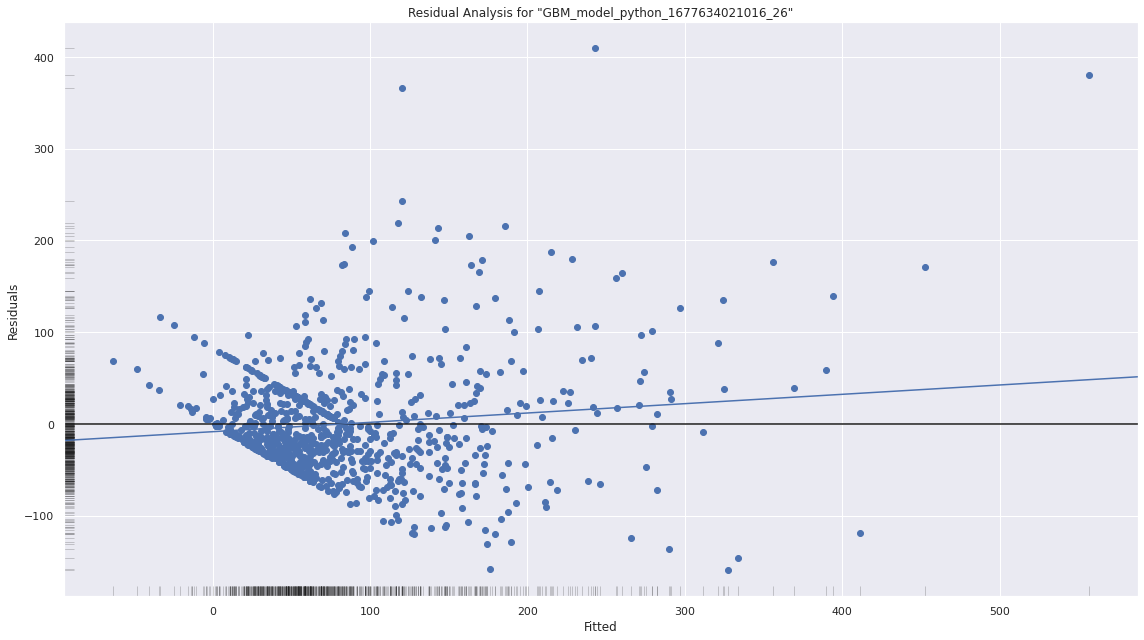

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

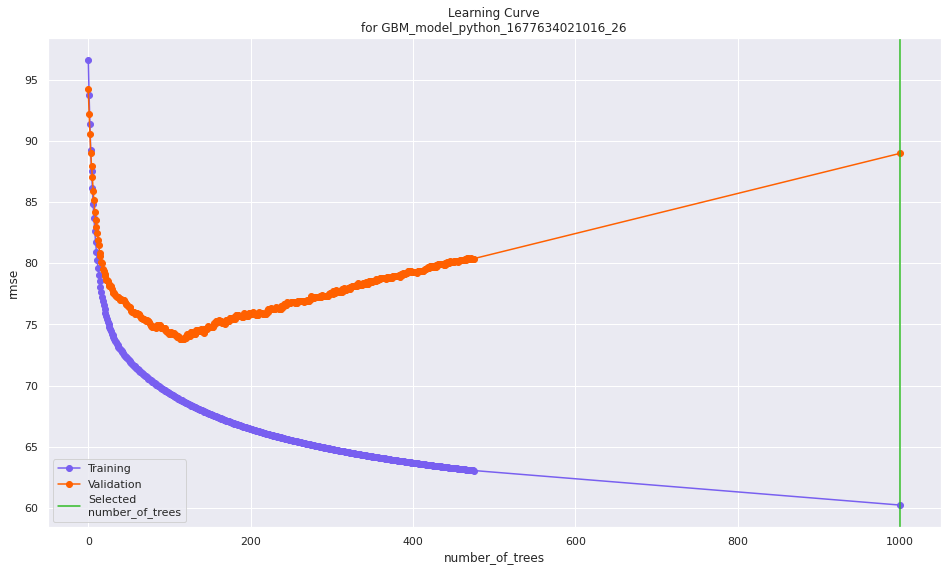

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

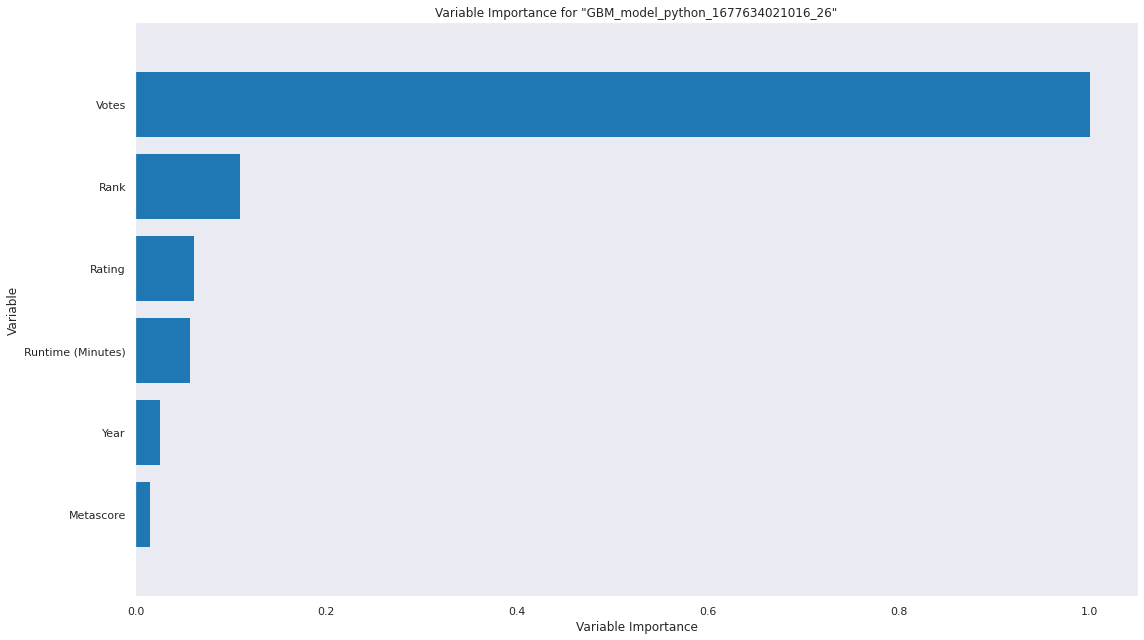

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

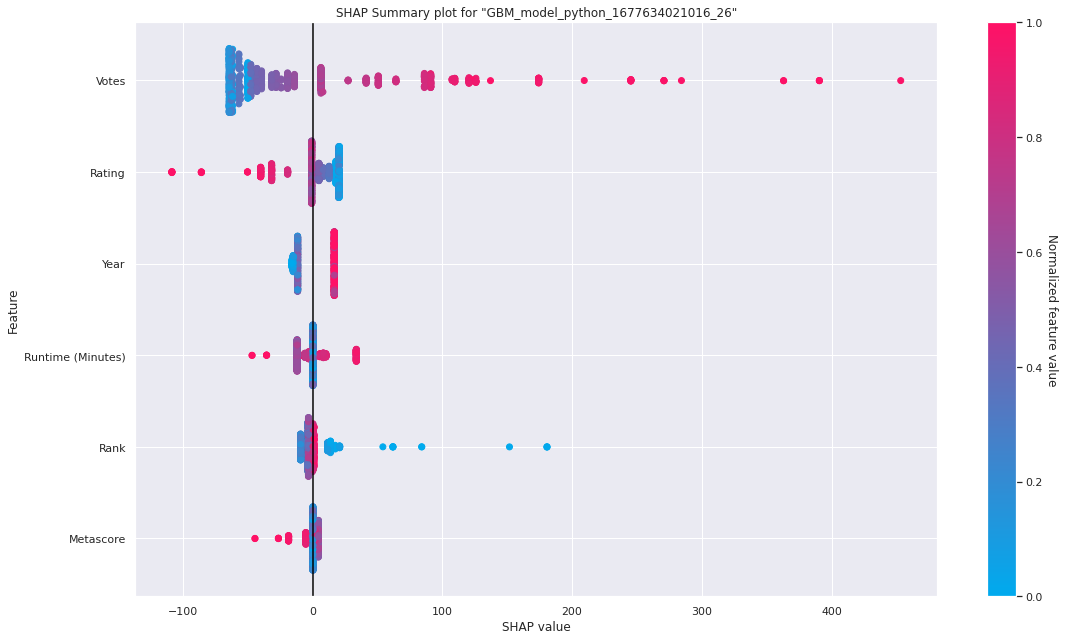

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

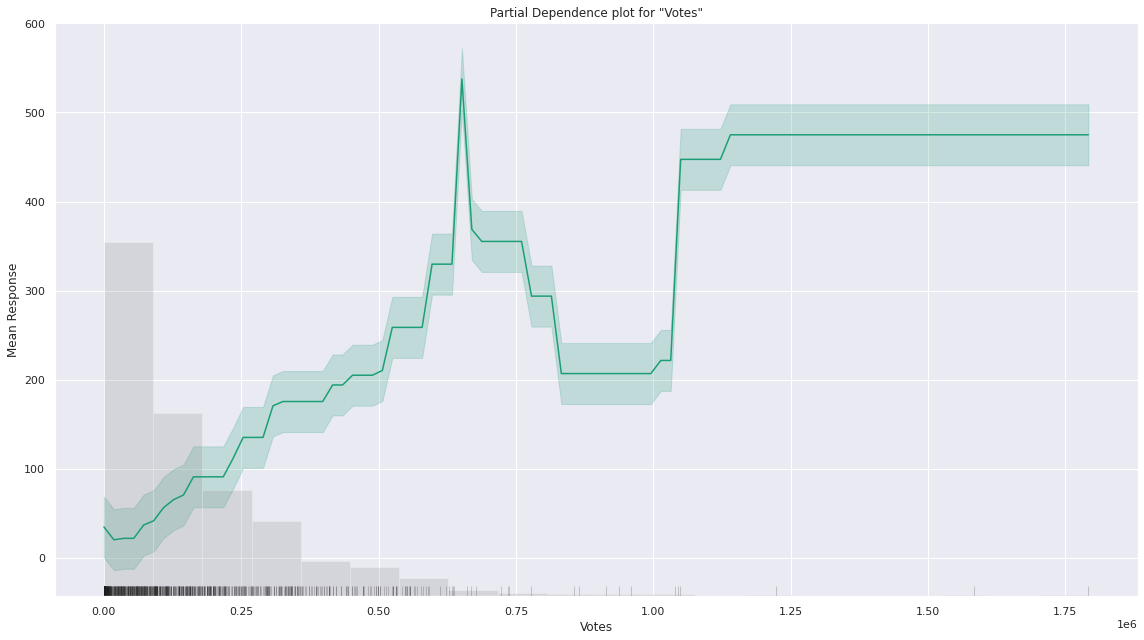

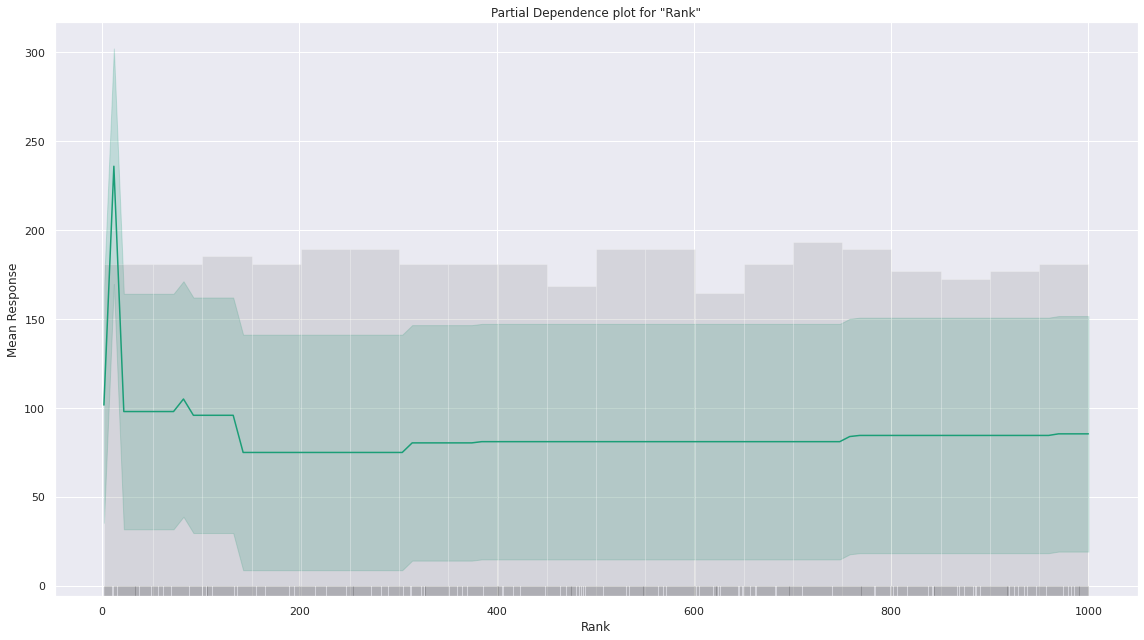

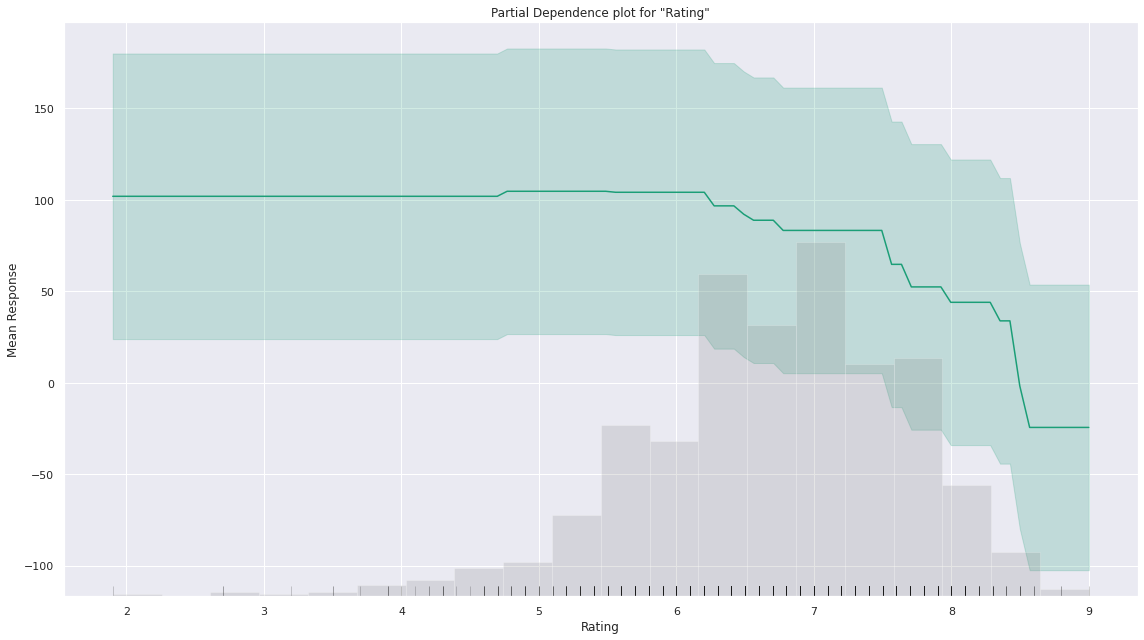

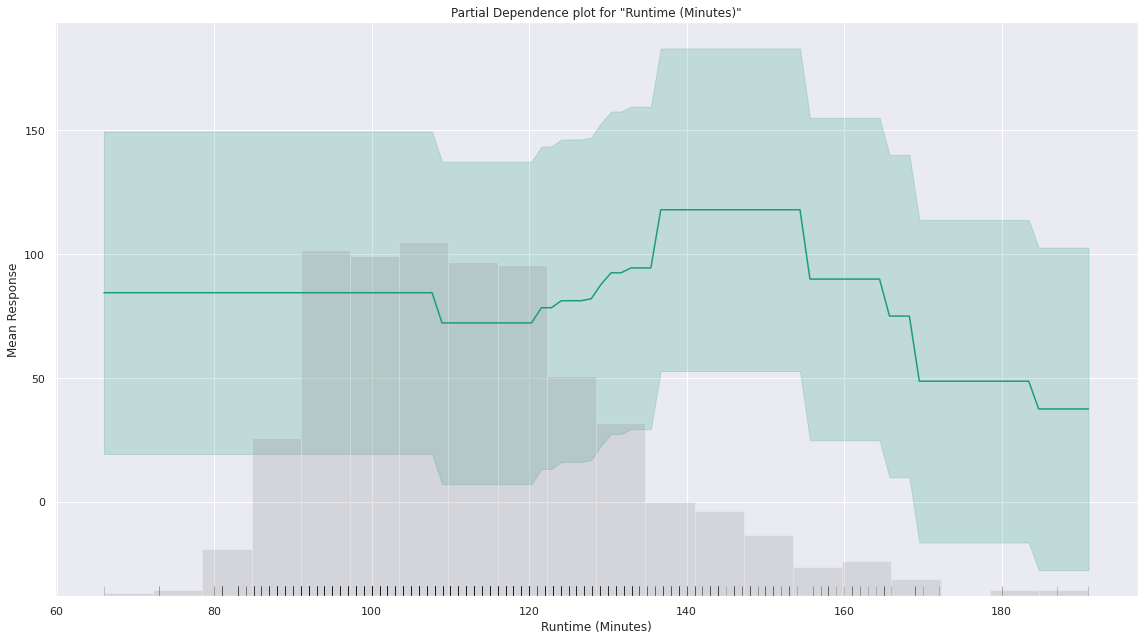

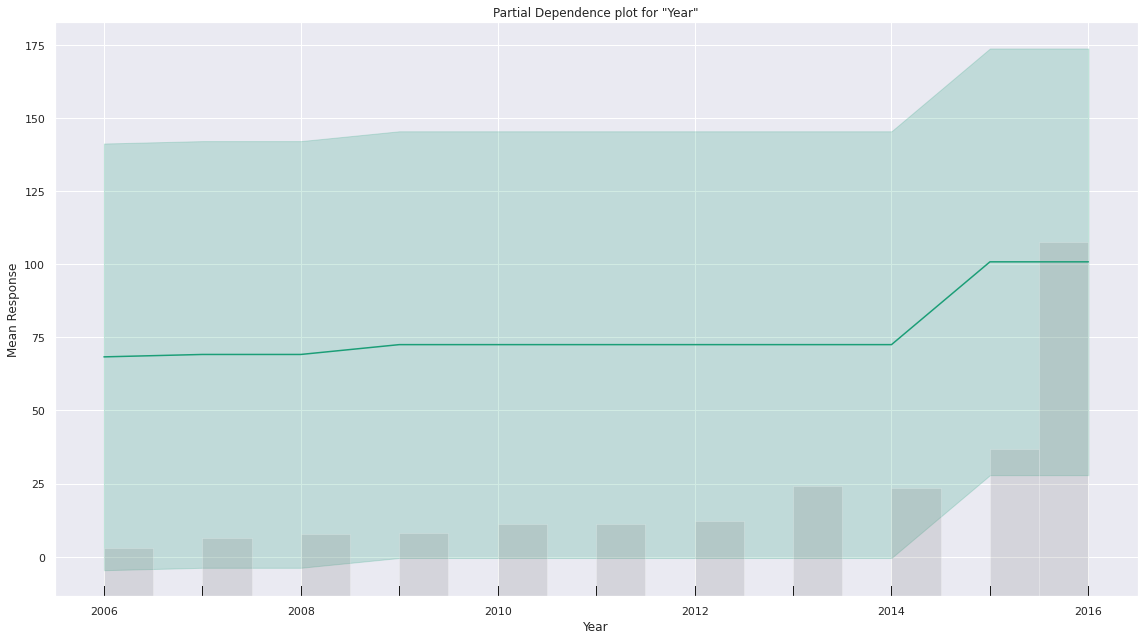

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

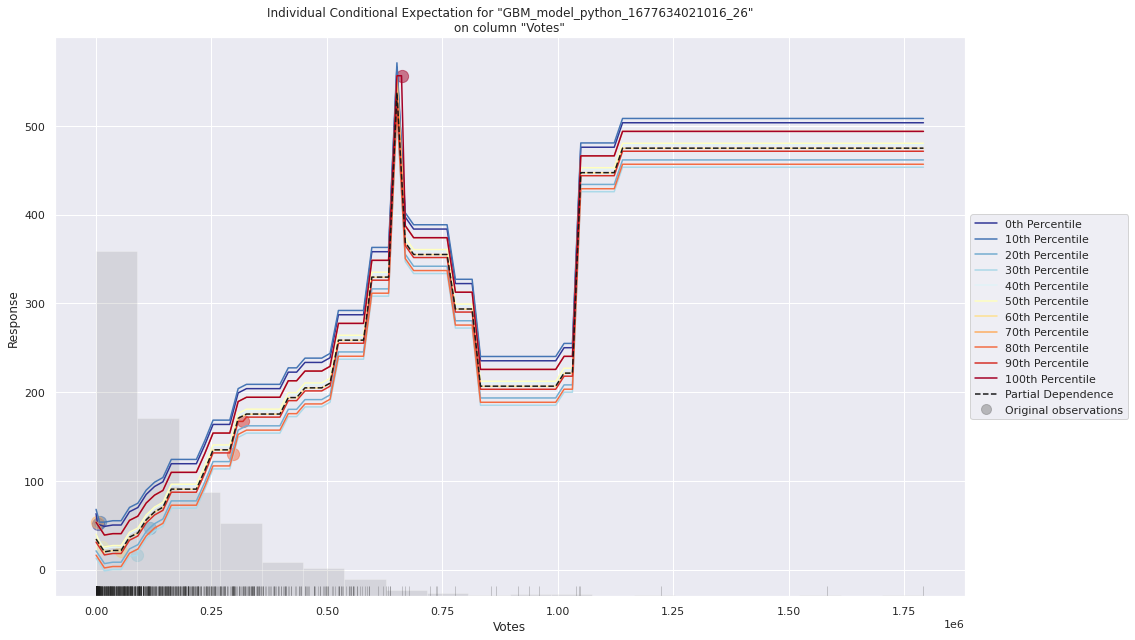

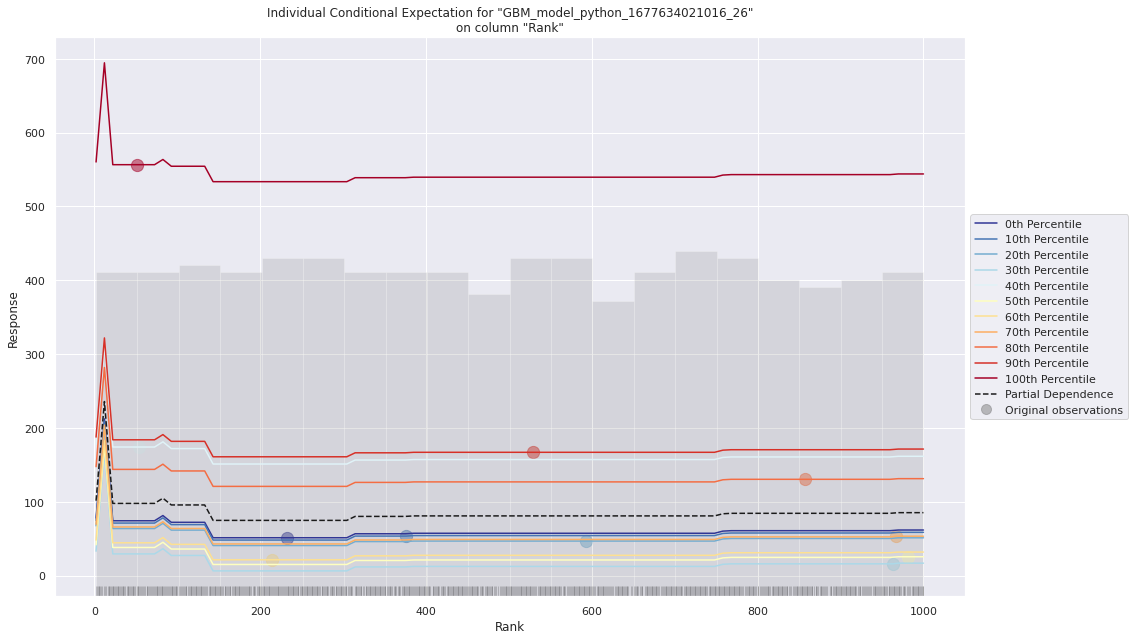

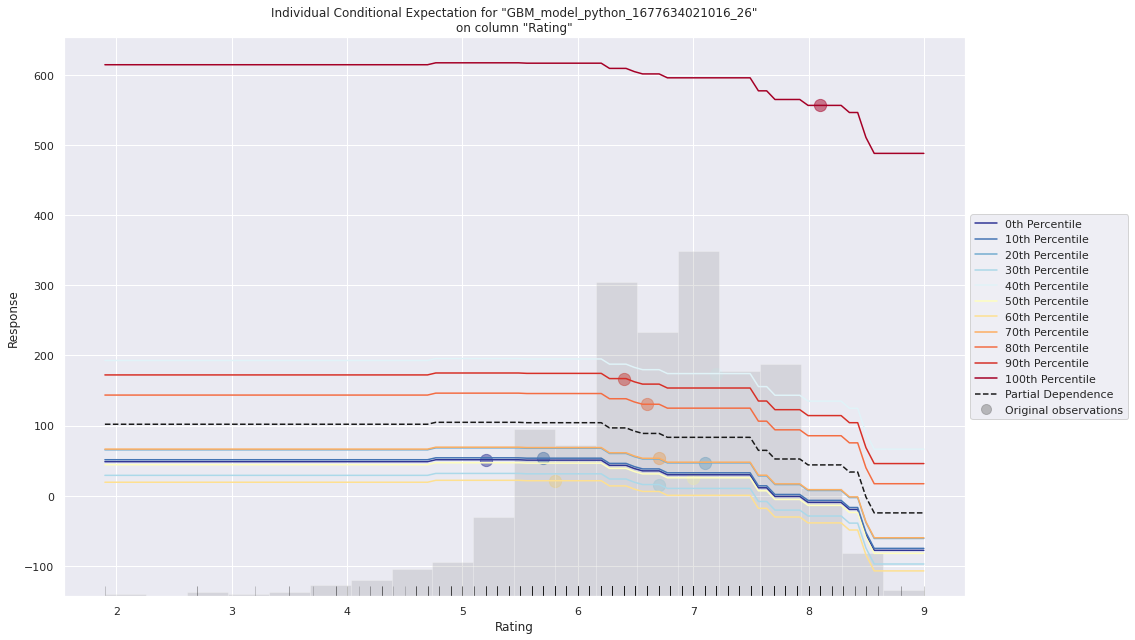

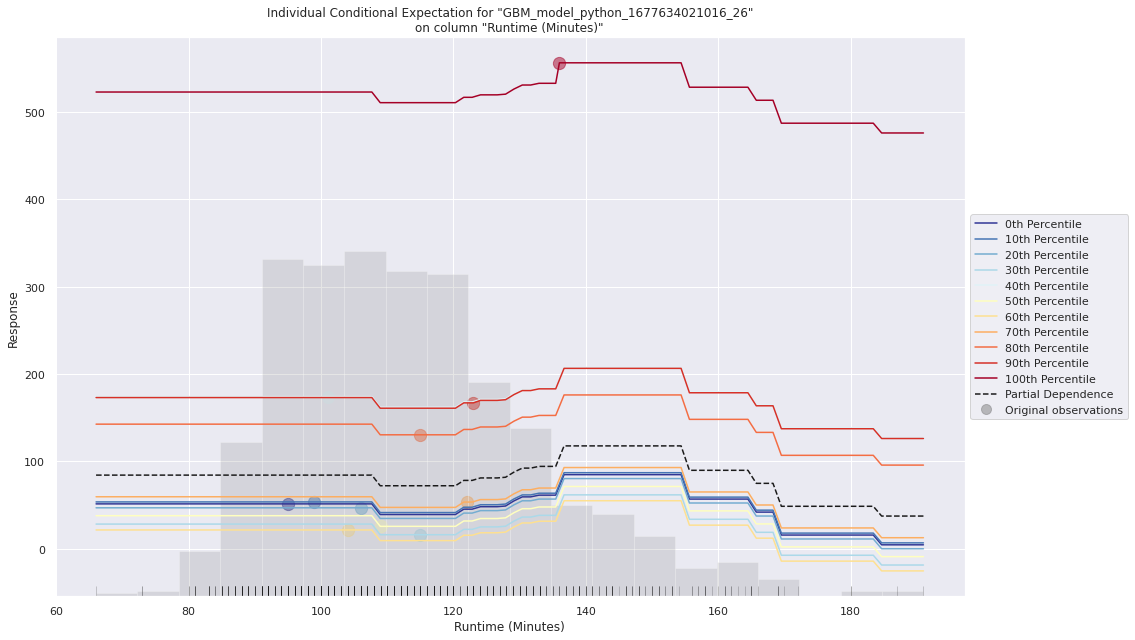

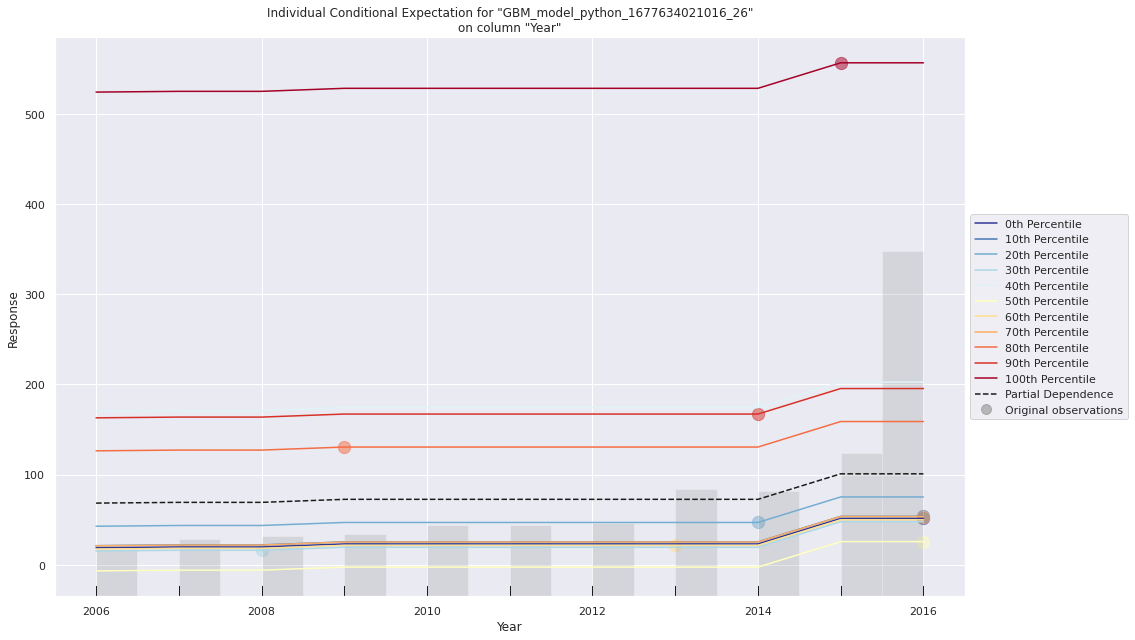

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

In [125]:
model_gbm.explain(train[1:1000,:])


In [126]:
# Variable importances from each algorithm
# Calculate magnitude of normalized GLM coefficients
from six import iteritems
import operator
from tabulate import tabulate

glm_varimp = data_glm.coef_norm()
for k,v in iteritems(glm_varimp):
    glm_varimp[k] = abs(glm_varimp[k])
    
# Sort in descending order by magnitude
glm_sorted = sorted(glm_varimp.items(), key = operator.itemgetter(1), reverse = True)
table = tabulate(glm_sorted, headers = ["Predictor variable", " Coefficient"], tablefmt = "orgtbl")
print("Variable Importances:\n\n" + table)

Variable Importances:

| Predictor variable   |    Coefficient |
|----------------------+----------------|
| Intercept            |      84.3306   |
| Votes                |      62.3271   |
| Rating               |      12.9208   |
| Year                 |       9.93716  |
| Rank                 |       6.05233  |
| Runtime (Minutes)    |       3.4272   |
| Metascore            |       0.132331 |


In [127]:
data_glm.varimp()


[('Votes', 62.32705307006836, 1.0, 0.6574800168619925),
 ('Rating', 12.920805931091309, 0.20730654338118118, 0.1362999096378604),
 ('Year', 9.937164306640625, 0.15943581185314856, 0.1048258602656136),
 ('Rank', 6.052326679229736, 0.09710593363728721, 0.06384521088524313),
 ('Runtime (Minutes)',
  3.427196979522705,
  0.05498730985515767,
  0.036153057410764675),
 ('Metascore',
  0.1323312222957611,
  0.0021231747014734317,
  0.0013959449385257075)]

In [128]:
model_gbm.varimp()


[('Votes', 21382030.0, 1.0, 0.7880458691752034),
 ('Rank', 2335003.5, 0.10920401383778809, 0.08605777200222064),
 ('Rating', 1319636.0, 0.06171705867029464, 0.048635873142769355),
 ('Runtime (Minutes)', 1220488.375, 0.0570800983349102, 0.044981735704940386),
 ('Year', 546214.375, 0.025545487261967176, 0.02013101571286101),
 ('Metascore', 329604.1875, 0.015415009122146026, 0.012147734262005253)]

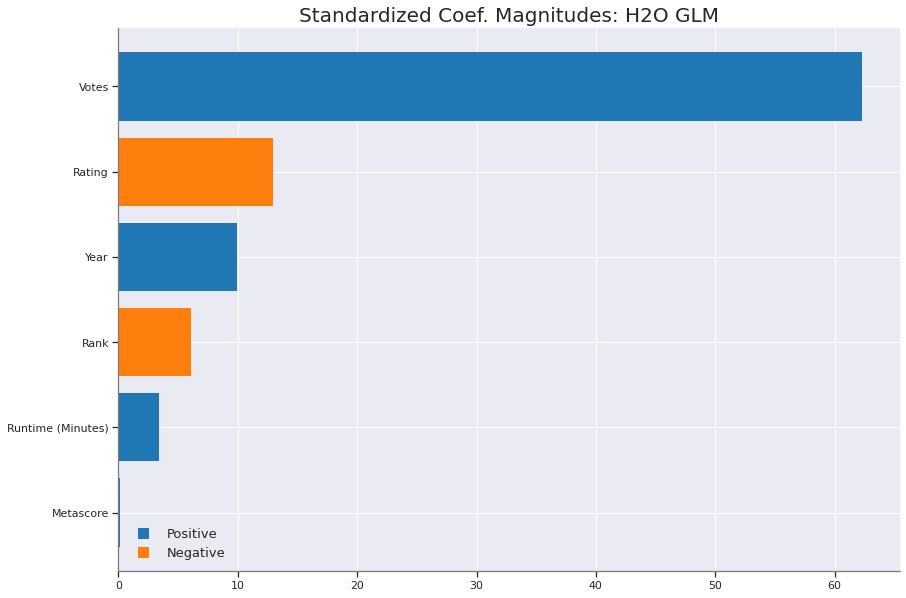

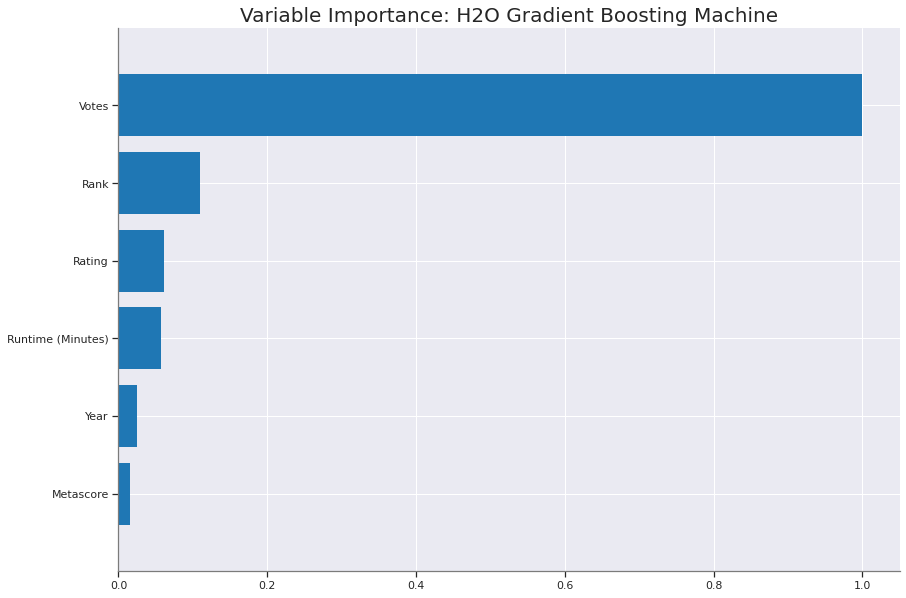

<Figure size 432x288 with 0 Axes>

In [129]:
data_glm.std_coef_plot()
model_gbm.varimp_plot()

**PERFORMANCES OF THE MODELS:**

In [130]:
# Model performance of GBM model on test data
model_gbm.model_performance(test)  

ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 7919.069016831992
RMSE: 88.98915111872903
MAE: 50.7061809405503
RMSLE: NaN
Mean Residual Deviance: 7919.069016831992

In [131]:
# Model performance of GBM model on test data
data_glm.model_performance(test)  

ModelMetricsRegressionGLM: glm
** Reported on test data. **

MSE: 5083.827721345246
RMSE: 71.30096578129391
MAE: 49.81604767936563
RMSLE: 1.5758889031888308
Mean Residual Deviance: 5083.827721345246
R^2: 0.41385133797406193
Null degrees of freedom: 95
Residual degrees of freedom: 89
Null deviance: 852306.7970564826
Residual deviance: 488047.4612491436
AIC: 1107.682893923752

**AUTOML ALGORITHM:**

In [132]:
def get_independent_variables(df, targ):
    C = [name for name in df.columns if name != targ and name !='Revenue (Millions)']
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in C:

            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    x=ints+enums+reals
    return x

In [133]:
X=get_independent_variables(train, myY) 
print(X)
print(myY)

['Rank', 'Year', 'Votes', 'Runtime (Minutes)', 'Rating', 'Metascore']
Revenue (Millions)


In [134]:
# Set up AutoML
run_time=333
aml = H2OAutoML(max_runtime_secs=run_time)

In [135]:
model_start_time = time.time()
  
aml.train(x=X,y=myY,training_frame=train) 

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),13/69
# GBM base models (used / total),2/26
# XGBoost base models (used / total),6/31
# DeepLearning base models (used / total),4/9
# DRF base models (used / total),0/2
# GLM base models (used / total),1/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5


In [136]:
execution_time = time.time() - model_start_time
print(execution_time)

335.9368875026703


**LEADERBOARD:**

In machine learning competitions and data science projects, a leaderboard is a table that displays the performance of different models on a particular task or dataset. The leaderboard typically ranks the models based on a metric or evaluation criterion, such as accuracy, F1 score, or mean squared error.

The purpose of a leaderboard is to compare the performance of different models and to identify the best-performing models for the task at hand. The leaderboard can be used to track the progress of different teams or participants in a competition, or to compare the performance of different algorithms and techniques in a data science project.

In a machine learning competition, the leaderboard is often publicly visible and is updated periodically as new models are submitted and evaluated. Participants can use the leaderboard to guide their development and tuning of their models, with the goal of improving their ranking on the leaderboard.

In a data science project, the leaderboard can be used to track the performance of different models during development and to select the best-performing model for deployment. The leaderboard can also be used to communicate the performance of the models to stakeholders and decision-makers.

Overall, a leaderboard provides a clear and objective way to compare the performance of different models and to identify the best-performing models for a particular task or dataset.

In [137]:
print(aml.leaderboard)


model_id                                                   rmse      mse      mae      rmsle    mean_residual_deviance
StackedEnsemble_AllModels_6_AutoML_2_20230301_13553     70.5221  4973.37  47.9092  nan                         4973.37
StackedEnsemble_BestOfFamily_7_AutoML_2_20230301_13553  70.9459  5033.31  47.9883    1.36358                   5033.31
StackedEnsemble_AllModels_4_AutoML_2_20230301_13553     71.125   5058.77  48.3201    1.39076                   5058.77
StackedEnsemble_BestOfFamily_5_AutoML_2_20230301_13553  71.1684  5064.94  48.0839    1.35143                   5064.94
StackedEnsemble_BestOfFamily_4_AutoML_2_20230301_13553  71.5516  5119.63  48.4675  nan                         5119.63
StackedEnsemble_AllModels_2_AutoML_2_20230301_13553     71.6106  5128.07  48.8009  nan                         5128.07
GBM_grid_1_AutoML_2_20230301_13553_model_21             71.6911  5139.61  48.0051  nan                         5139.61
StackedEnsemble_AllModels_3_AutoML_2_20230301_13

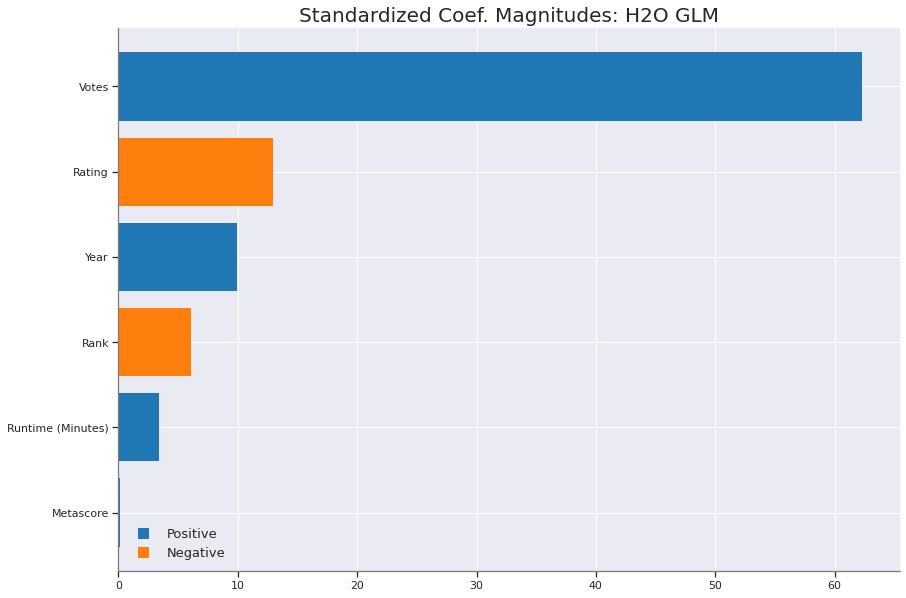

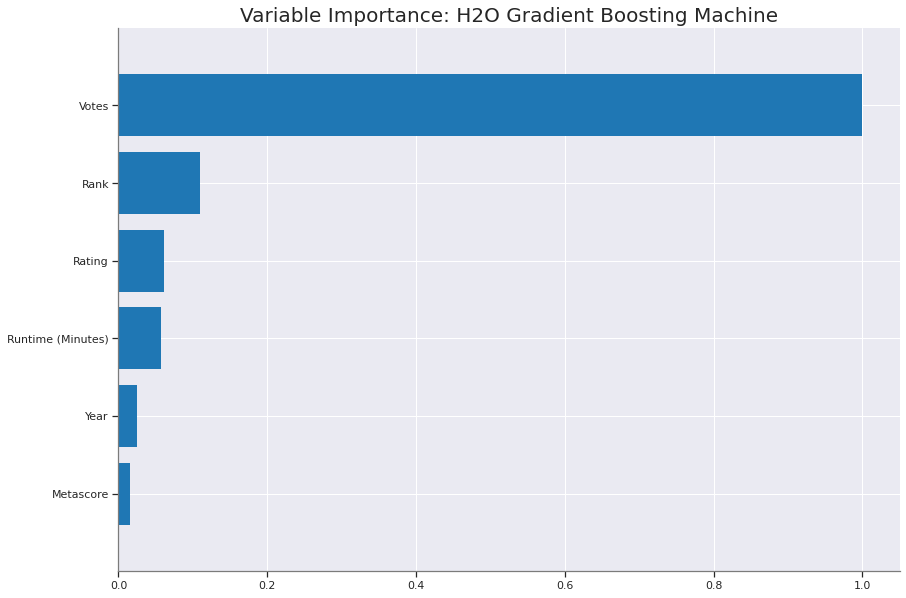

<Figure size 432x288 with 0 Axes>

In [138]:
data_glm.std_coef_plot()
model_gbm.varimp_plot()

In [139]:
best_model = h2o.get_model(aml.leaderboard[0,'model_id'])
best_model.algo

'stackedensemble'

 A Stacked Ensemble is a type of machine learning model that combines the predictions of multiple individual models to produce a final prediction. The individual models used in the ensemble are often diverse in terms of their structure and training data, which can lead to improved performance over a single model.

In [140]:
if best_model.algo in ['xgboost','drf','gbm']:
  best_model.varimp_plot()
else:
  print(best_model.params)

{'model_id': {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'ModelKeyV3', 'schema_type': 'Key<Model>'}, 'name': 'StackedEnsemble_AllModels_6_AutoML_2_20230301_13553', 'type': 'Key<Model>', 'URL': '/3/Models/StackedEnsemble_AllModels_6_AutoML_2_20230301_13553'}, 'input': None}, 'training_frame': {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'AutoML_2_20230301_13553_training_py_421_sid_a82c', 'type': 'Key<Frame>', 'URL': '/3/Frames/AutoML_2_20230301_13553_training_py_421_sid_a82c'}, 'input': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'AutoML_2_20230301_13553_training_py_421_sid_a82c', 'type': 'Key<Frame>', 'URL': '/3/Frames/AutoML_2_20230301_13553_training_py_421_sid_a82c'}}, 'response_column': {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'ColSpecifierV3', 'schema_type': 'VecSpecifier'}, 'col

The first part is an if-else statement that checks whether the algorithm used for the best model is one of xgboost, drf, or gbm. If the algorithm is one of these three, it calls the varimp_plot() method of the best_model object. This method is used to plot the variable importance for the features in the dataset, which can be helpful in understanding which features are most predictive.

If the algorithm used for the best model is not one of xgboost, drf, or gbm, the script prints the parameters of the best_model object. These parameters contain information about the training data, response variable, validation data, and the models used in the ensemble.

In [141]:
other_best_model = h2o.get_model(aml.leaderboard[5,'model_id'])
other_best_model.varimp(use_pandas=True)

In [142]:
train, validate, test = np.split(
    dff.sample(frac=1, random_state=42), [int(0.6 * len(dff)), int(0.8 * len(dff))]
)

train = h2o.H2OFrame(train)
validate = h2o.H2OFrame(validate)
test = h2o.H2OFrame(test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [143]:
gbm_parameters = {
    "learn_rate": [i * 0.01 for i in range(1, 11)],
    "max_depth": list(range(2, 11)),
    "sample_rate": [i * 0.1 for i in range(5, 11)],
    "col_sample_rate": [i * 0.1 for i in range(1, 11)],
}

In [144]:
search_criteria = {"strategy": "RandomDiscrete", "max_models": 36, "seed": 1}


In [145]:
gbm_grid2 = H2OGridSearch(
    model=H2OGradientBoostingEstimator,
    grid_id="gbm_grid2",
    hyper_params=gbm_parameters,
    search_criteria=search_criteria,
)

In [147]:
gbm_grid2.train(
    x=X, y=y, training_frame=train, validation_frame=validate, ntrees=1000, seed=1
)

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


,col_sample_rate,learn_rate,max_depth,sample_rate,model_ids,residual_deviance
,0.4,0.08,6.0,0.9,gbm_grid2_model_28,9783505234.3976269
,0.5,0.01,10.0,1.0,gbm_grid2_model_24,10020276833.2164688
,0.5,0.03,2.0,0.6000000,gbm_grid2_model_26,10043706055.7155228
,0.1,0.02,9.0,0.8,gbm_grid2_model_16,10050367158.7121162
,0.5,0.05,7.0,0.9,gbm_grid2_model_2,10090123856.6305904
,0.2,0.04,5.0,0.9,gbm_grid2_model_29,10124246493.2662277
,1.0,0.01,2.0,0.5,gbm_grid2_model_23,10168338322.3519077
,0.1,0.06,8.0,0.9,gbm_grid2_model_66,10175283366.6442757
,0.7000000,0.03,6.0,1.0,gbm_grid2_model_6,10226472780.5254192
,0.7000000,0.07,2.0,0.6000000,gbm_grid2_model_32,10240341656.1800213


Hyperparameters are parameters in a machine learning algorithm that are set before the learning process begins. These parameters are not learned from the data, but rather are set manually or by using an optimization algorithm. Hyperparameters control the behavior of the learning algorithm and can significantly impact the performance of the resulting model.

In [148]:
gbm_gridperf2 = gbm_grid2.get_grid(sort_by="residual_deviance", decreasing=False)
gbm_gridperf2

,col_sample_rate,learn_rate,max_depth,sample_rate,model_ids,residual_deviance
,0.4,0.08,6.0,0.9,gbm_grid2_model_28,9783505234.3976269
,0.5,0.01,10.0,1.0,gbm_grid2_model_24,10020276833.2164688
,0.5,0.03,2.0,0.6000000,gbm_grid2_model_26,10043706055.7155228
,0.1,0.02,9.0,0.8,gbm_grid2_model_16,10050367158.7121162
,0.5,0.05,7.0,0.9,gbm_grid2_model_2,10090123856.6305904
,0.2,0.04,5.0,0.9,gbm_grid2_model_29,10124246493.2662277
,1.0,0.01,2.0,0.5,gbm_grid2_model_23,10168338322.3519077
,0.1,0.06,8.0,0.9,gbm_grid2_model_66,10175283366.6442757
,0.7000000,0.03,6.0,1.0,gbm_grid2_model_6,10226472780.5254192
,0.7000000,0.07,2.0,0.6000000,gbm_grid2_model_32,10240341656.1800213


In [149]:
list_hyperparameters = []
for i in range(36):
    hyperparameters = gbm_gridperf2.get_hyperparams_dict(i)
    list_hyperparameters.append(hyperparameters)

Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperp

**Explanation of each of the hyperparameters you mentioned:**

learn_rate: This hyperparameter controls the step size taken during the optimization process in gradient-based algorithms such as Gradient Boosting Machines (GBM) or XGBoost. A smaller learning rate can lead to slower convergence but can result in a more accurate model.

max_depth: This hyperparameter controls the maximum depth of a tree in decision tree-based algorithms such as Random Forest or XGBoost. A larger value of max_depth can result in a more complex model that can capture more intricate relationships in the data, but can also increase the risk of overfitting.

sample_rate: This hyperparameter controls the fraction of rows (observations) to be randomly sampled at each iteration during the training process in gradient-based algorithms such as GBM or XGBoost. A smaller value of sample_rate

col_sample_rate: is a hyperparameter used in machine learning algorithms for feature selection and regularization. It refers to the fraction of columns (features) that are randomly selected for each tree or iteration during the construction of a random forest or gradient boosting model.

In [150]:
models = gbm_gridperf2.models
list_residual_deviance = []
for i in range(36):
    model = models[i]
    performance_metrics = model.model_performance(validate)
    residual_deviance = performance_metrics.mean_residual_deviance()
    list_residual_deviance.append(residual_deviance)

In [151]:
for i in range(36):
    list_hyperparameters[i]["Residual_Deviance"] = list_residual_deviance[i]
hyperparameters_dataframe = pd.DataFrame(list_hyperparameters)
print(hyperparameters_dataframe)

    col_sample_rate  learn_rate  max_depth  sample_rate  Residual_Deviance
0               0.4        0.08          6          0.9       9.783505e+09
1               0.5        0.01         10          1.0       1.002028e+10
2               0.5        0.03          2          0.6       1.004371e+10
3               0.1        0.02          9          0.8       1.005037e+10
4               0.5        0.05          7          0.9       1.009012e+10
5               0.2        0.04          5          0.9       1.012425e+10
6               1.0        0.01          2          0.5       1.016834e+10
7               0.1        0.06          8          0.9       1.017528e+10
8               0.7        0.03          6          1.0       1.022647e+10
9               0.7        0.07          2          0.6       1.024034e+10
10              0.6        0.09          2          0.8       1.026121e+10
11              0.8        0.06          9          0.6       1.027769e+10
12              0.3      

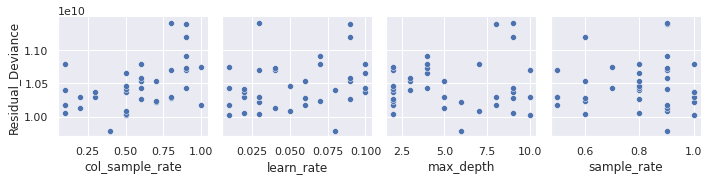

In [152]:
sns.pairplot(
    hyperparameters_dataframe,
    y_vars=["Residual_Deviance"],
    x_vars=["col_sample_rate", "learn_rate", "max_depth", "sample_rate"],
)

**Answers to the following questions:**

**1) Is the relationship significant?**

**Solution:** Since the R^2 is 0.9, we can conclude that the relationship is very significant and also all features' p value is 0.


**2) Are any model assumptions violated?**

**Solution:** No, the model assumptions are not violated because,

a) Linear relationship- The graph for dependent and independent variable needs to be linear by keeping other variables constant. When target variable is plotted against all other independent variables, linear relation is observed for few of them. Hence this assumption is not violated.

b) No or little multicollinearity-This can be determined by correlation matrix. Since there is no multicollinearity, the assumptions are not violated.


**3) Is there any multicollinearity in the model?**

**Solution:** No, there is no multicollinearity in the model.

**4) In the multivariate models are predictor variables independent of all the other predictor variables?**

**Solution:**  Variables are said to be independent when there is no relation between them. To check this relation, correlation matrix can be used, or it can be observed from graphs too whether there is any pattern followed or not. Hence, no, they are not all independent of each other.


**5) In multivariate models rank the most significant predictor variables and exclude insignificant ones from the model.**

**Solution:** The most significant predictor variables are Votes-> Rank-> Rating-> Runtime (Minutes)-> Year-> Metascore


**6) Does the model make sense?**

**Solution:** For a model to make sense, it is important to have the r-squared value as 1. In this model, the r-squared value is 0.9 which is considered as best model. Hence, it can be concluded that the model does make sense.


**7) Does regularization help?**

**Solution:** Yes, the RMSE in the best model is much higher than in regularization.


**8) Which independent variables are significant?**

**Solution:** Votes


**9) Which hyperparameters are important?**

**Solution:** The combination of col_sample_rate, learn_rate, max_depth, and sample_rate can have a significant impact on the performance of an XGBoost model, and that hyperparameter tuning can lead to significant improvements in model performance.


**10) Coding Professionalism?**

**Solution:** Yes


**Conclusion:**

In this notebook, I examined how the H2O library is used to:

1) Describing a dataset

2) Train models

3) Make predictions on a trained model

4) Examined the effects of Ridge and LASSO regularization on the GLM Model.

5) Built GLM and GBM models

6) Studied variable importance

7) Studied hyperparameters using Random Grid Search Method

**REFERENCES:**

Professor's AutoML Notebooks- https://github.com/nikbearbrown/AI_Research_Group/tree/main/Kaggle_Datasets/AutoML

StackOverflow- https://stackoverflow.com/questions/48676228/h2o-glm-with-regularization

TowardsDataScience- https://towardsdatascience.com/democratising-machine-learning-with-h2o-7f2f79e10e3f 



**LICENSE:**

MIT License

Copyright (c) 2023 Prarthna Nemade

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.